# Class 07 - Outline

[1 - Clusters and cluster computing](#one)  
[2 - What is MPI](#two)  
[3 - Communication between processes](#three)    
[4 - Parallell programming design patterns](#four)  
[5 - Conclusions](#five)  

In [1]:
from IPython.display import Image

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import re
from math import *

%matplotlib inline

In [3]:
%alias clean rm -f *.c *.exe *.py *.pyc *.s .*f95 *.o *.fo *log *.h *.cc *.mod *.dat

In [4]:
%clean

Remember that you may to load modules or set aliases and paths in Makefiles (see below) to the right location if you are not using a system installed gcc (or modules)

In [5]:
%alias gcc /usr/local/gcc-7.3.0/bin/gcc -static -L/usr/local/gcc-7.3.0/lib64 -I/usr/local/gcc-7.3.0/include 
%alias g++ /usr/local/gcc-7.3.0/bin/g++ -static -L/usr/local/gcc-7.3.0/lib64 -I/usr/local/gcc-7.3.0/include 
%alias gfortran /usr/local/gcc-7.3.0/bin/gfortran -static -L/usr/local/gcc-7.3.0/lib64 -I/usr/local/gcc-7.3.0/include 

In [6]:
%alias

Total number of aliases: 16


[('cat', 'cat'),
 ('clean',
  'rm -f *.c *.exe *.py *.pyc *.s .*f95 *.o *.fo *log *.h *.cc *.mod *.dat'),
 ('cp', 'cp'),
 ('g++',
  '/usr/local/gcc-7.3.0/bin/g++ -static -L/usr/local/gcc-7.3.0/lib64 -I/usr/local/gcc-7.3.0/include'),
 ('gcc',
  '/usr/local/gcc-7.3.0/bin/gcc -static -L/usr/local/gcc-7.3.0/lib64 -I/usr/local/gcc-7.3.0/include'),
 ('gfortran',
  '/usr/local/gcc-7.3.0/bin/gfortran -static -L/usr/local/gcc-7.3.0/lib64 -I/usr/local/gcc-7.3.0/include'),
 ('ldir', 'ls -F -o --color %l | grep /$'),
 ('lf', 'ls -F -o --color %l | grep ^-'),
 ('lk', 'ls -F -o --color %l | grep ^l'),
 ('ll', 'ls -F -o --color'),
 ('ls', 'ls -F --color'),
 ('lx', 'ls -F -o --color %l | grep ^-..x'),
 ('mkdir', 'mkdir'),
 ('mv', 'mv'),
 ('rm', 'rm'),
 ('rmdir', 'rmdir')]

<a id="one"></a>

# 1 - Clusters and cluster computing

## Clusters

- Collection of computing nodes connected in a local network.  
- In scientific computing: used to tackle problems unfeasible to single nodes.
- May be constituted by specialized HPC (see top500.org) or off-the-shelf nodes.  

A tiny cluster:

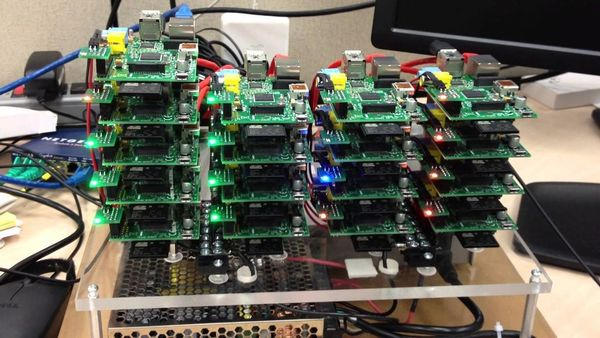

In [7]:
Image("raspberry_cluster.jpeg")

- Each computing node runs an operating system instance.  
    - **Local caches and local address spaces**
    - **Local disks**
- Hypothetically, each node may be running other tasks.  
- Nodes are not required to be homogeneous (in practice, they are).

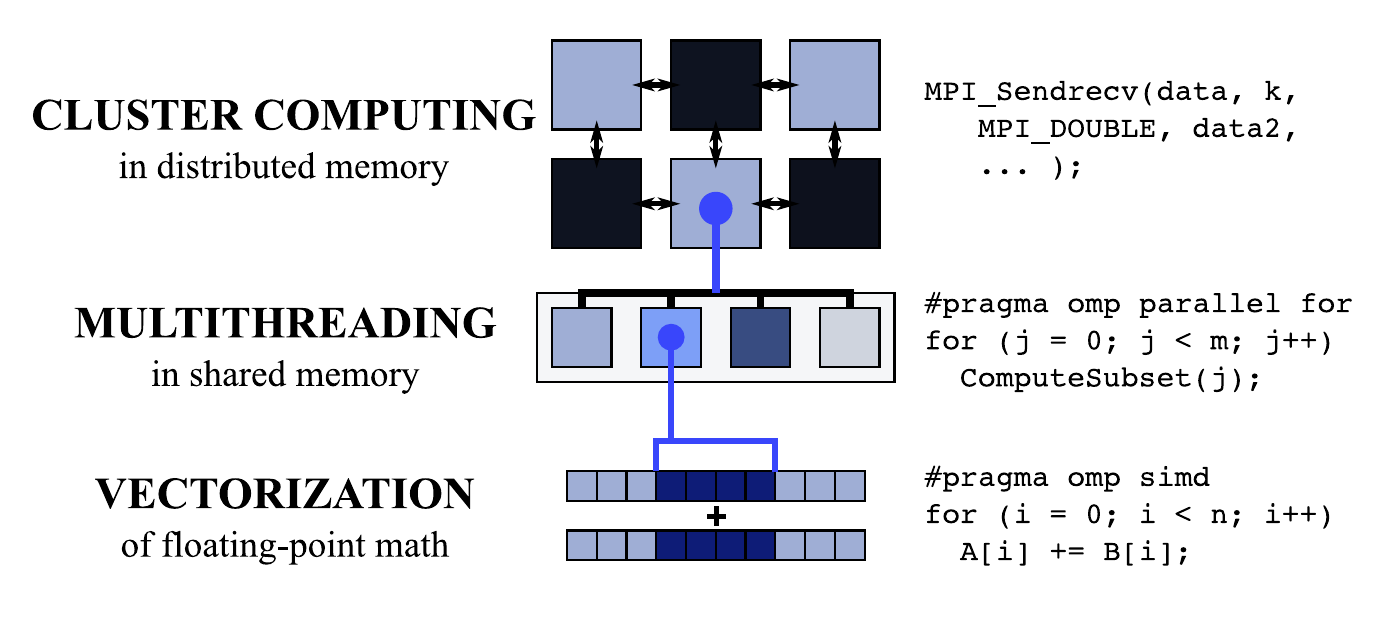

In [8]:
Image("par_layers.png")

- Sharing of compute load with a communication protocol:  
    - (Gigabit) Ethernet
    - High-speed fabric (e. g. [Infiniband](#https://en.wikipedia.org/wiki/InfiniBand) or [Intel Omnipath](#https://en.wikipedia.org/wiki/Omni-Path)).  
    - Network topology may be rather complex.  
    - Each node may be itself a NUMA archicture with separated multicore sockets.  

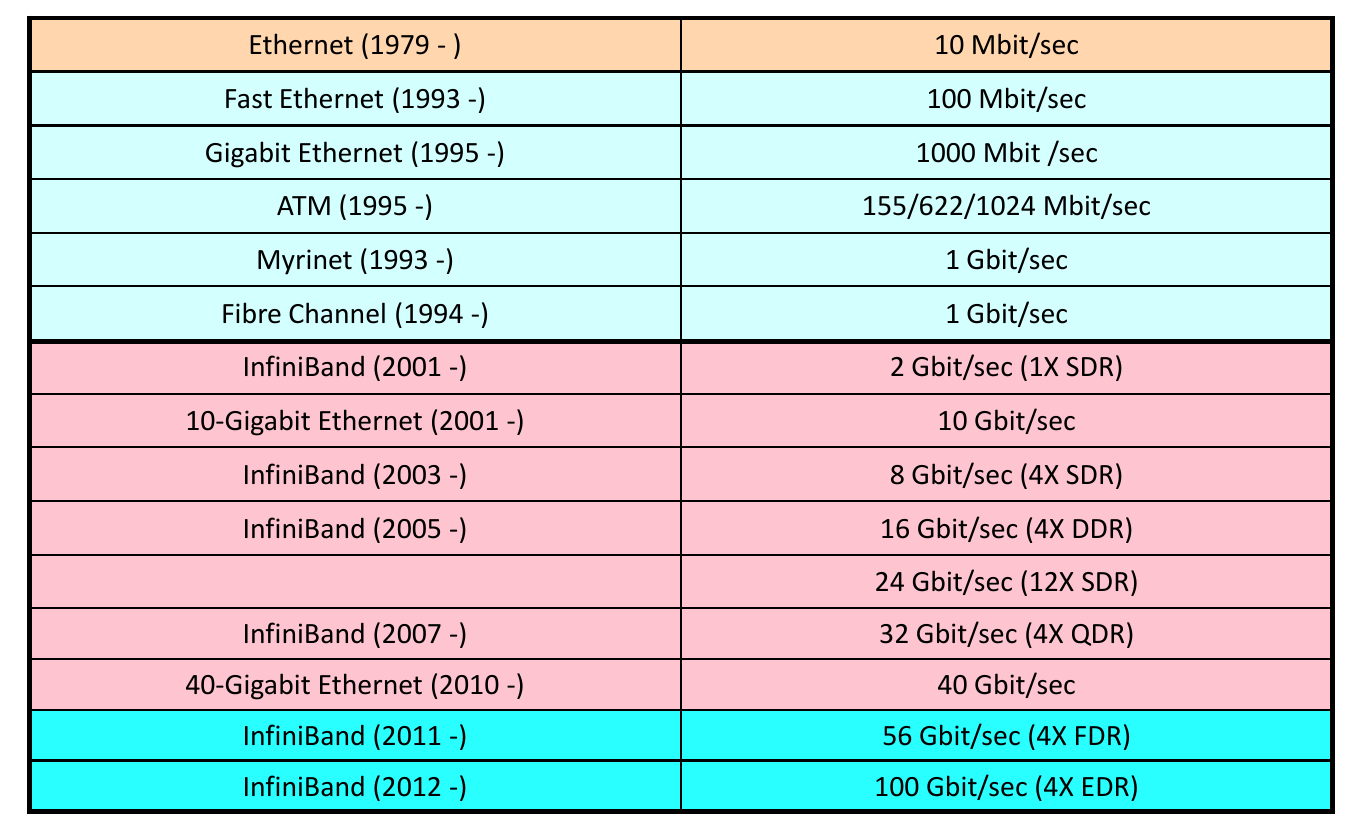

In [9]:
Image("networks.png")

<a id="two"></a>

# 2 - What is MPI

Since each node is a separate environment, to do parallel computing they need *pass messages* to each other. **MPI** (*Message Passing Interface*) is standard specification for message passing.  

- Implemented in several libraries, open source and proprietary.
    - [OpenMPI](#https://www.open-mpi.org/) and [MPICH](#https://www.mpich.org/) commonly used (and available in distro repositories ...)
- Designed for distributed computing (but it can be used for shared multiprocessing).  
- Portable.  
- C, C++ and Fortran bindings available.  
- Currently, version 3 of the standard available.  

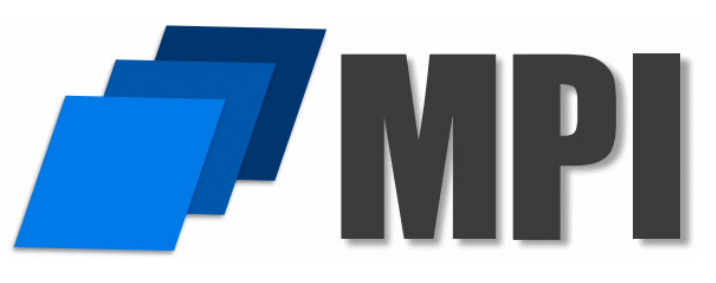

In [10]:
Image("mpi_logo.png")

Can be combined with OpenMP (but it is not easy to assess advantages; case by case study):

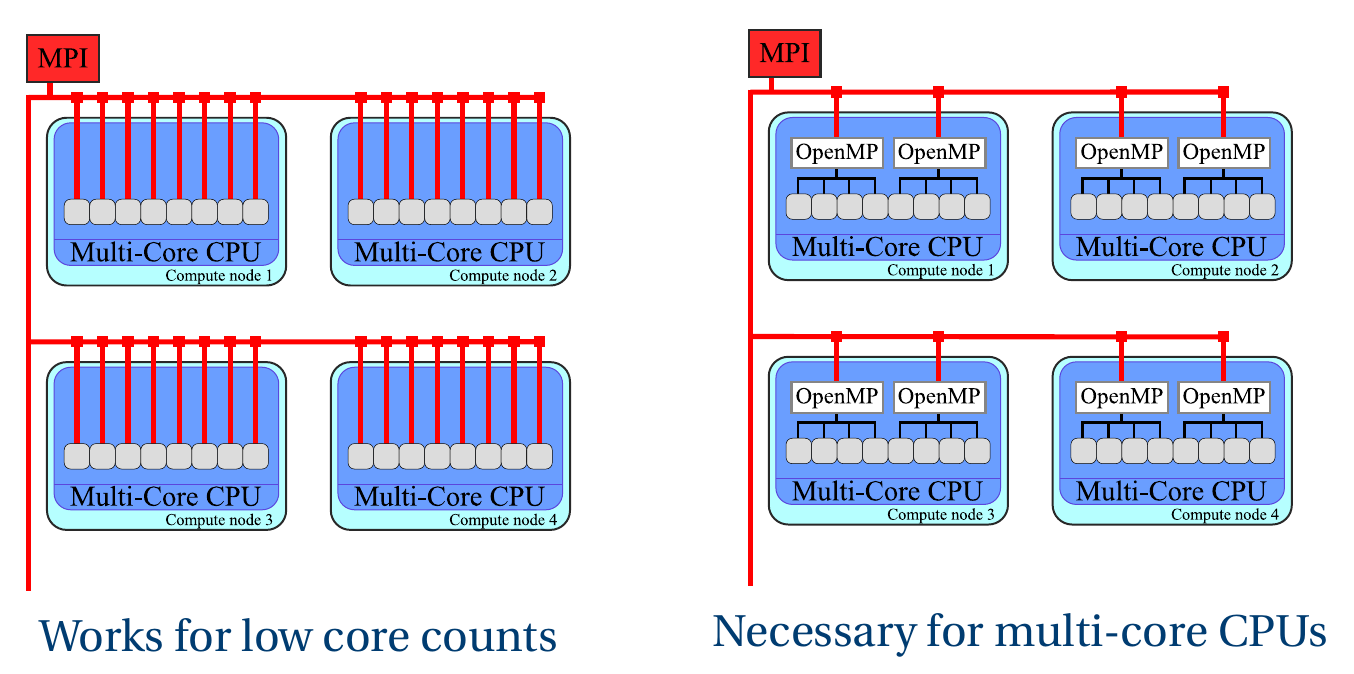

In [11]:
Image("hybrid.png")

**MPI features**

- The Program consists of a collection of processes (often counted by their *rank*).
- Number of processes almost always fixed at program startup time.  
- Repetita iuvant: Each node has a local address space.  
- Logically shared data must be partioned.  
- Processes communicate by explicit **send/receive** pairs.

In the the jungle of (dead) parallel programming protocols, MPI is an old but well adapted crocodile:

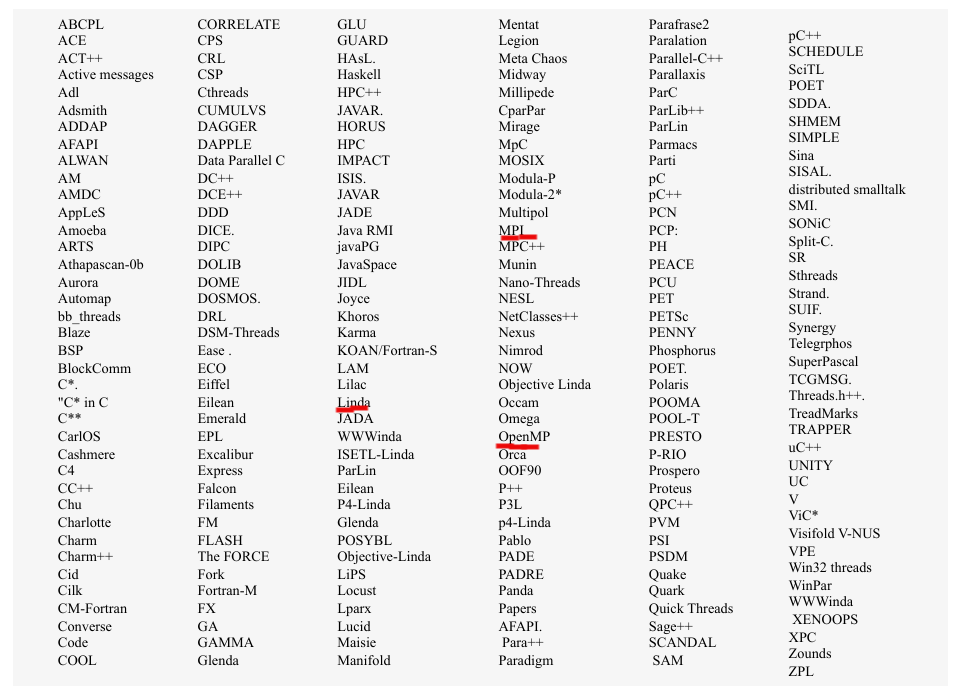

In [12]:
Image("envs90.png")

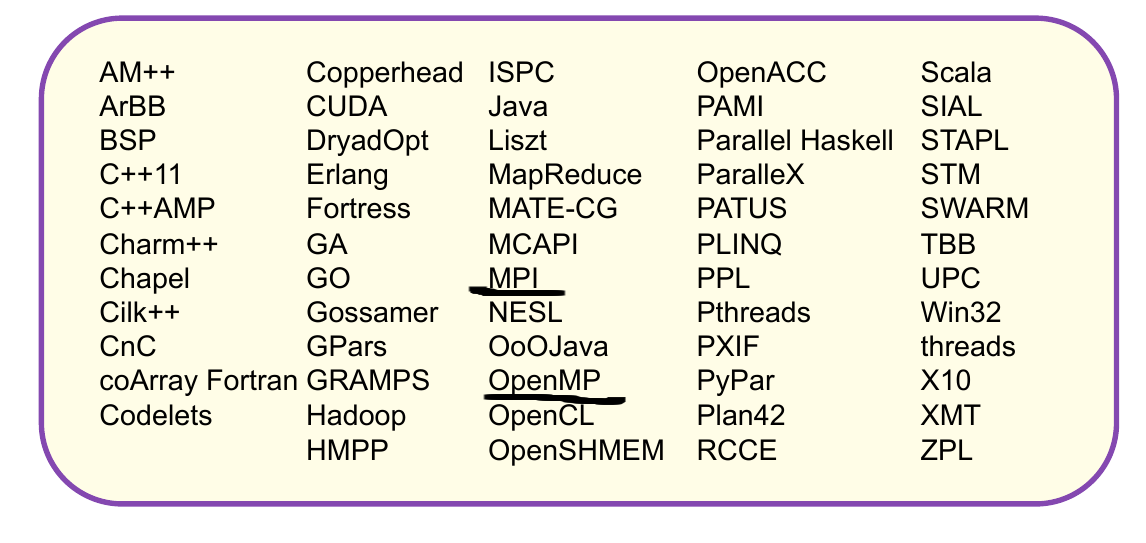

In [13]:
Image("envs10.png")

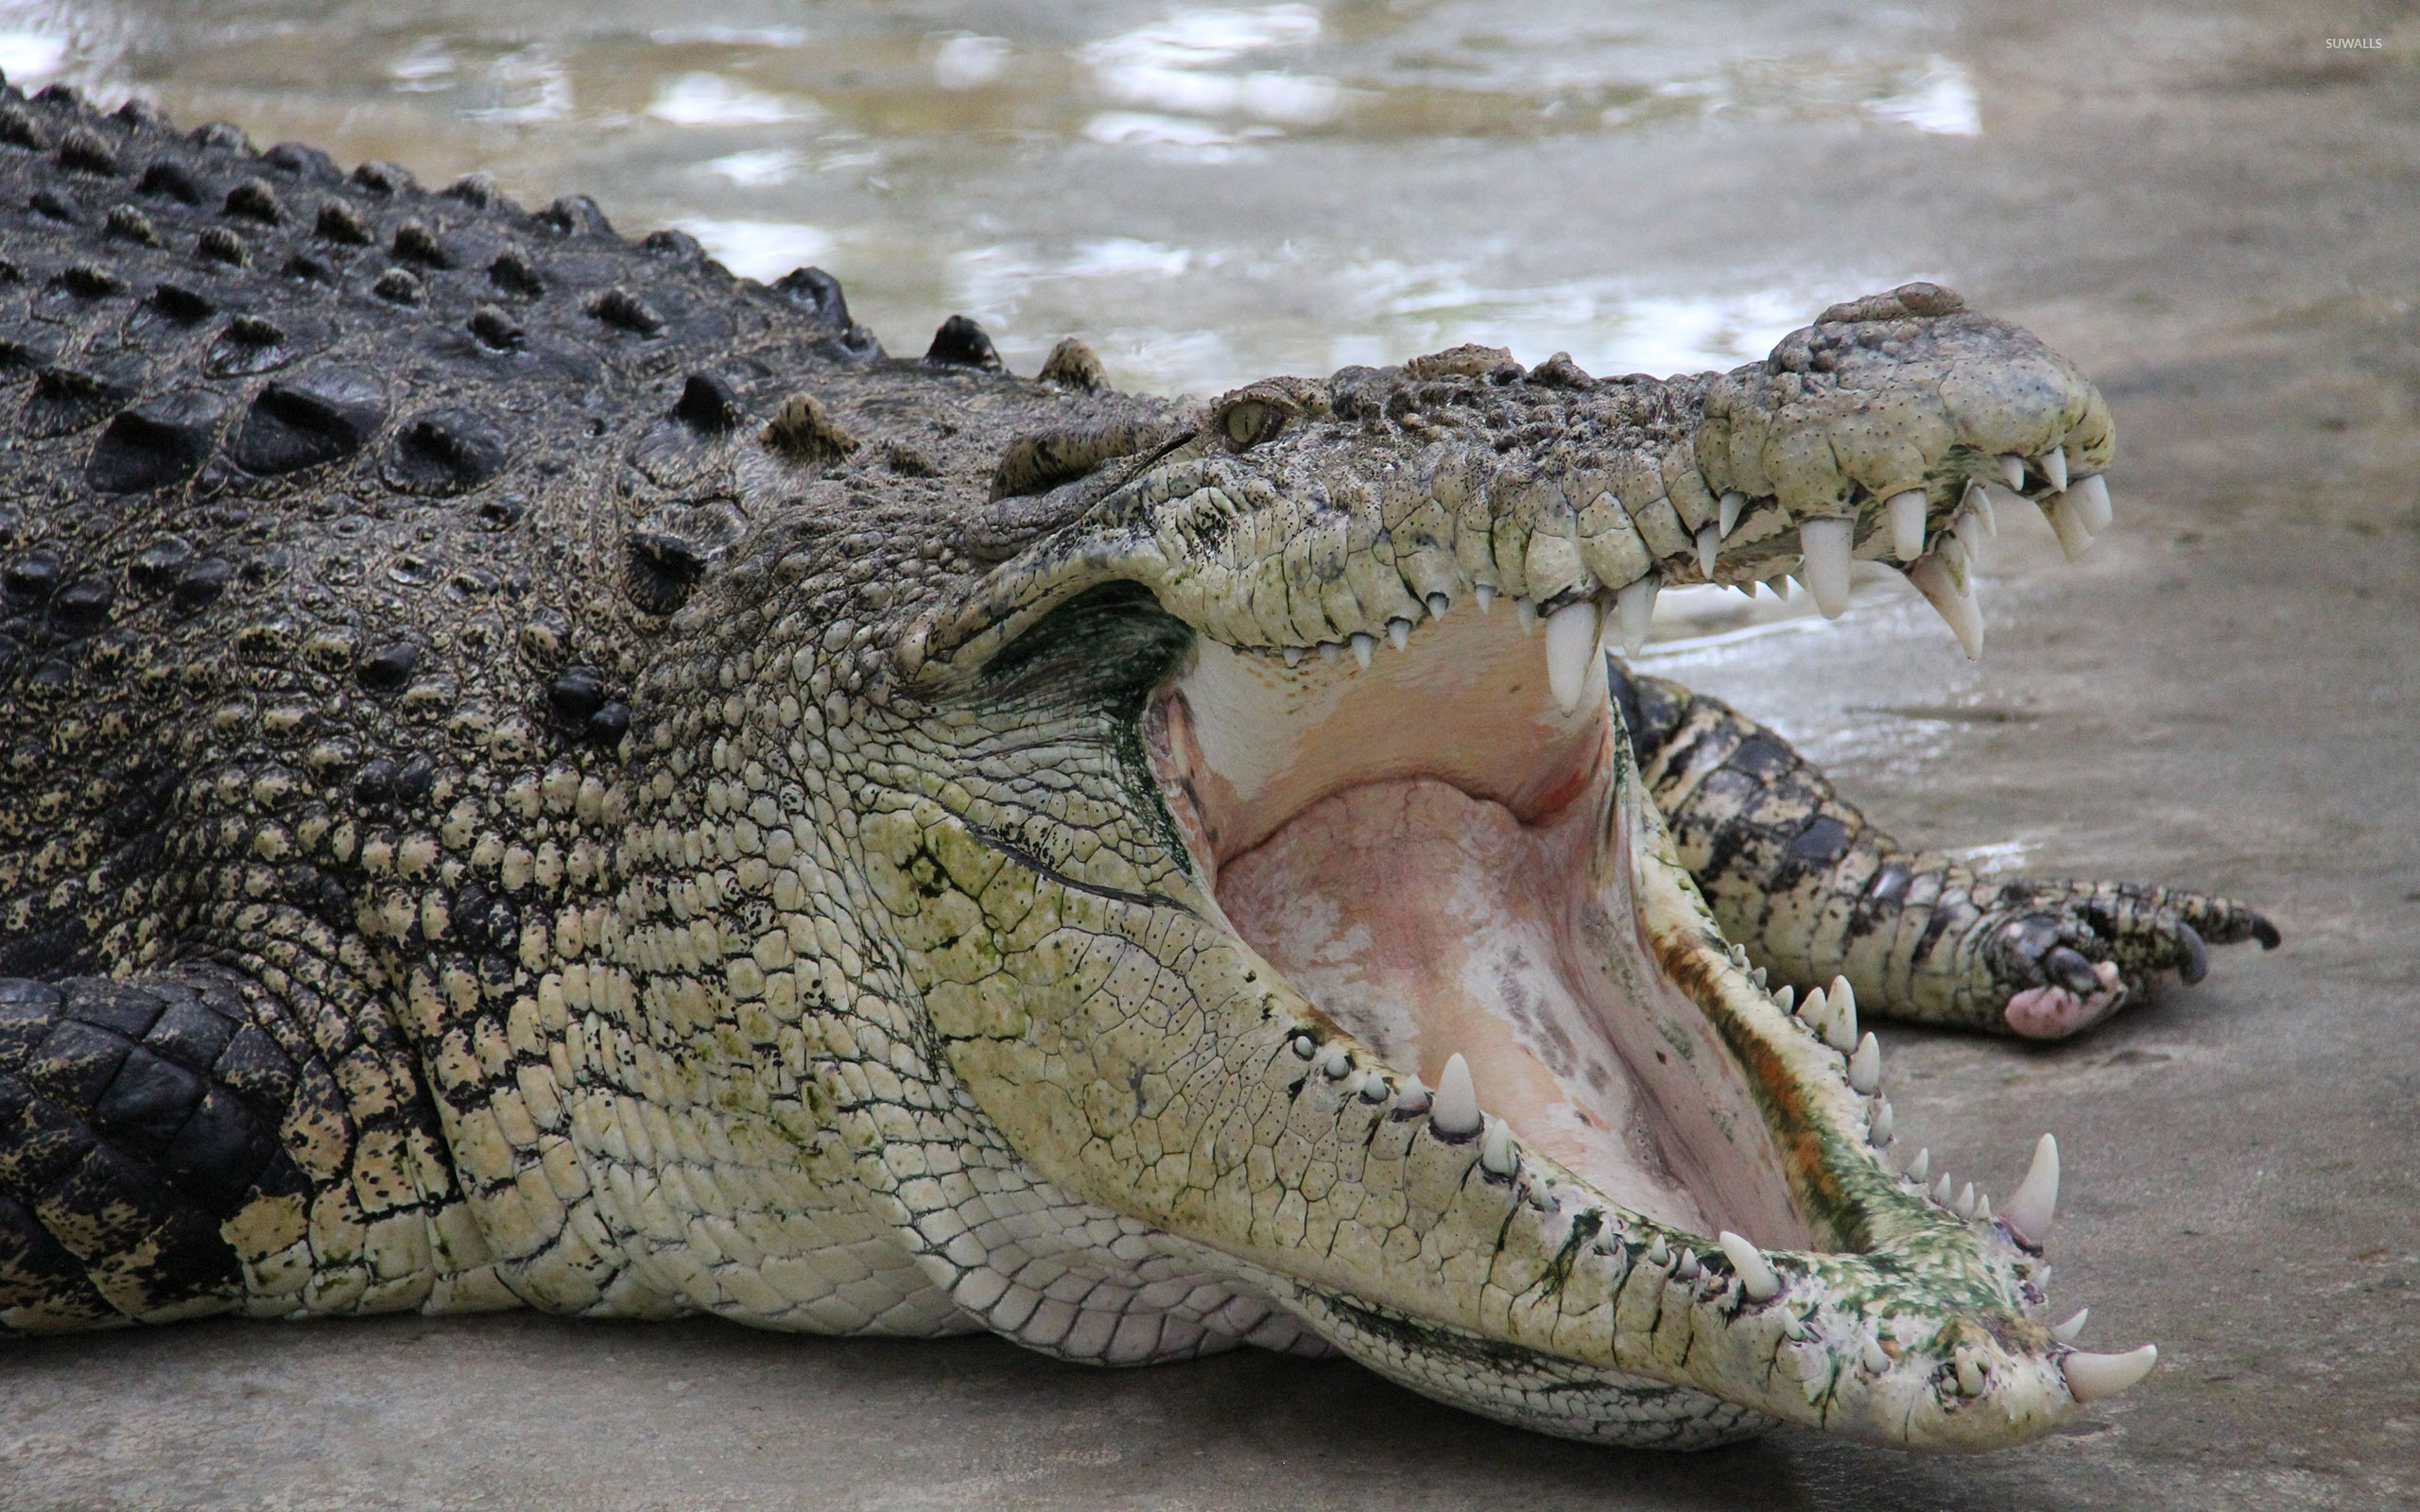

In [14]:
Image("crocodile-37253-2560x1600.jpg")

Consolidates last 30 years of parallel wisdom.

### Using MPI

When an MPI program is run, multiple processes are executed and work of separate blocks of data.  
The collection of processes involved in a computationis called **a process group**.

- Process groups can be split in subgroups.
- MPI functions work in separates *contexts* and don't interfere with each other.
    - ~Complementary way of thinking with respect to OpenMP.  

Being a library, MPI offers is used with *functions* in place of *processor directives*:

- OpenMP: `#pragma omp parallel`
- MPI: `MPI_Send(void* sendbuffer, int count, MPI_Datatype datatype, int destination_process, tag, MPI_Communicator COMM)`

there are (relatively) minor differences between the C, C++ and F95 version of each function.

In [15]:
%%writefile hello.cc
#include <iostream>
#include <cstdlib>
#include <mpi.h>

using namespace std;

int main()
{
    int rank, size;
   
    //start MPI 
    // C: MPI_Init()
    MPI::Init();
    
    //get a process ID
    // C: MPI_Comm_rank(MPI_COMM_WORLD, &rank)
    rank = MPI::COMM_WORLD.Get_rank();

    cout<<"Hello World! from process "<<rank<<endl;    
    
    //check htop (or similar)
    system("stress --timeout 5s --cpu 1");
    
    //get comunicator size
    //  C: MPI_Comm_size(MPI_COMM_WORLD, &size)
    size = MPI::COMM_WORLD.Get_size();
    
    //close processes
    cout<<"Closing comunicator with "<<size<<" procs"<<endl;
    // C: MPI_Finalize()
    MPI::Finalize();
}

Writing hello.cc


In [16]:
%%bash
mpicxx -o hello.exe hello.cc -lmpi

Each language has a dedicated prepocessor wrapper used to compile with MPI.  
Multiple processes are spawned by `mpirun` or `mpiexec`:

In [17]:
%%bash
./hello.exe

Hello World! from process 0
stress: info: [7272] dispatching hogs: 1 cpu, 0 io, 0 vm, 0 hdd
stress: info: [7272] successful run completed in 5s
Closing comunicator with 1 procs


In [18]:
%%bash
mpirun -n 1 ./hello.exe

Hello World! from process 0
stress: info: [7347] dispatching hogs: 1 cpu, 0 io, 0 vm, 0 hdd
stress: info: [7347] successful run completed in 5s
Closing comunicator with 1 procs


In [19]:
%%bash
mpirun -n 2 ./hello.exe

Hello World! from process 0
Hello World! from process 1
stress: info: [7355] dispatching hogs: 1 cpu, 0 io, 0 vm, 0 hdd
stress: info: [7354] dispatching hogs: 1 cpu, 0 io, 0 vm, 0 hdd
stress: info: [7355] successful run completed in 5s
Closing comunicator with 2 procs
stress: info: [7354] successful run completed in 5s
Closing comunicator with 2 procs


check what happens with `top` or `htop`.

Note: to use MPICH you need to et up the `mpd` daemon first.

The Fortran version is quite similar:

In [20]:
%%writefile hello.f95
program hello
    use mpi
    implicit none

    integer :: rank, procs, ierr
    
    rank  = 0
    procs = 0

    !start MPI 
    call MPI_Init(ierr)
    
    !Get a process ID
    call MPI_Comm_rank(MPI_COMM_WORLD, rank, ierr)
    write(*,*) 'Hello World! from process ', rank
    
    !check htop (or similar); only with std=gnu
    call EXECUTE_COMMAND_LINE('stress --timeout 10s --cpu 1')
    
    !Get number of procs
    call MPI_Comm_size(MPI_COMM_WORLD, procs, ierr)
    
    !close processes
    write(*,*) 'Closing MPI context with ',procs,' processes'
    call MPI_Finalize(ierr)
    
end program hello

Overwriting hello.f95


In [21]:
%%bash
mpifort -o hello.exe hello.f95 -lmpi
mpirun -n 3 ./hello.exe

Hello World! from process 0
Hello World! from process 1
Hello World! from process 2
stress: info: [7401] dispatching hogs: 1 cpu, 0 io, 0 vm, 0 hdd
stress: info: [7403] dispatching hogs: 1 cpu, 0 io, 0 vm, 0 hdd
stress: info: [7402] dispatching hogs: 1 cpu, 0 io, 0 vm, 0 hdd
stress: info: [7403] successful run completed in 5s
stress: info: [7401] successful run completed in 5s
Closing comunicator with 3 procs
Closing comunicator with 3 procs
stress: info: [7402] successful run completed in 5s
Closing comunicator with 3 procs


bash: line 1: mpifort: command not found


wrapper names can change: `mpifort`, `mpif90` ...

*Like threads, processes are numbered from 0 to size-1*

**MPI_Init** initializes the MPI library and creates the contexts. Must be called before any other MPI function.
**MPI_Finalize** frees memory allocated by the MPI library and closes every MPI program.
**MPI_Comm_size** returns the number of processes in the process group (like `omp_get_num_threads`).
**MPI_Comm_rank** returns the ID of a specific process (like `omp_get_thread_num`).  

**MPI Communicators**  is an opaque data type. They consist of two parts, a context and a process group. The communicator allows to control how groups of messages interact a write modular software.  
By default we have `MPI_COMM_WORLD` which puts all processes in the same context.

Almost all MPI functions take a Communicator in input.

To wrap up, a minimal MPI program will have:  
- `MPI_Init()`.  
- `MPI_Finalize()`.  
- a communicator, often `MPI_COMM_WORLD`.  

### Sending and Receiving Data 

The MPI workhorses:

    int MPI_Send (void* buf, int count, MPI_Datatype datatype, 
        int dest, int tag, MPI_Comm comm)

**MPI_Send** performs a **blocking** send of the specified data (*count* copies of type *datatype,* stored in *buf*) to the specified destination (rank *dest* within communicator *comm*), with message ID *tag*.

**Blocking**: the function returns as soon as the buffer, `buf`, can be safely used. **Requires acknowledgment by receiver**.

*tag* is not mandatory and can be 0 or `MPI_ANY_TAG`.

    int MPI_Recv (void* buf, int count,MPI_Datatype datatype, int source, 
        int tag, MPI_Comm comm,MPI_Status* status)

**MPI_Recv** performs a blocking receive of specified data from specified source whose parameters match the send; information about transfer is stored in *status* which can also be `NULL` or `MPI_IGNORE_STATUS`.

#### C/C++ MPI Datatypes

| MPI datatype | C datatype | C++ datatype 
| :---: | :---: | :---: 
|MPI_CHAR | char | char 
|MPI_WCHAR | wchar_t | wchar_t 
|MPI_SHORT | signed short | signed short
|MPI_INT | signed int | signed int
|MPI_LONG | signed long | signed long
|MPI_SIGNED_CHAR | signed char | signed char
|MPI_UNSIGNED_CHAR | unsigned char | unsigned char
|MPI_UNSIGNED_SHORT | unsigned short | unsigned short
|MPI_UNSIGNED | unsigned int | unsigned int
|MPI_UNSIGNED_LONG | unsigned long | unsigned long int
|MPI_FLOAT | float | float
|MPI_DOUBLE | double | double
|MPI_LONG_DOUBLE | long double | long double
|MPI_BOOL | | bool
|MPI_COMPLEX | | Complex<float>
|MPI_DOUBLE_COMPLEX | | Complex<double>
|MPI_LONG_DOUBLE_COMPLEX | | Complex<long double>

#### Fortran  Datatypes

| MPI datatype | Fortran datatype  
| :---: | :---: | :---:
|MPI::CHARACTER	|CHARACTER
|MPI::INTEGER | INTEGER
|MPI::REAL |REAL
|MPI::DOUBLE_PRECISION | DOUBLE PRECISION
|MPI::LOGICAL | LOGICAL
|MPI::F_COMPLEX | COMPLEX

The data in a message to send or receive is described by a triple:

    (address, count, datatype)
 
An MPI datatype is defined as:
- Predefined, simple data type from the language (e.g., MPI_INT).  
- Complex data types: contiguous blocks or custom types.  
    - E.g. ... A classical particle described by 3 positions and 3 velocities"
    - MPI_Datatype PART;  
    - MPI_Type_contiguous( 6, MPI_DOUBLE, &PART );
    - MPI_Type_commit( &PART );
 
To send data for a single particle:
    
    MPI_Send (buff, 1, PART, Dest, tag, MPI_COMM_WORLD);


### Who goes there? Getting the right message

A receiving process identifies messages with the pair:

    (source, tag)!

Where:
- *Source* is the rank of the sending process.  
    - Can relax source checking by specifying MPI_ANY_SOURCE
    - This is a useful way to insert race conditions into an MPI program ...  
- *Tag* is a user-defined integer to help the receiver keep track of different messages from a single source.
    - Can relax tag checking by specifying MPI_ANY_TAG as the tag in a receive.  

Tags are useful to sort several messages sent by the same source. 

The third way of messing up MPI programs is `MPI_IGNORE_STATUS`. Status is an MPI datatype formed by another triple:

- Sender ID (rank). Stored in MPI_SOURCE element.  
- The tag of the message. 
- The length of the message. 

`Status` is a structure and specific values can be accessed as usual:

    MPI_Status status;
    MPI_Send(...);
    MPI_Recv(...);
    printf("Sender rank and tag: %d %d\n",status.MPI_SOURCE, status.MPI_TAG);
    
or by using `MPI_Probe`.  
The length of the message does not have a predefined element in the status structure but we can use`MPI_Get_count`:

    MPI_Get_count(
        MPI_Status* status,
        MPI_Datatype datatype,
        int* count)

Note that:
    
        MPI_Send(buffer, count_sent, MPI_INT, 0, 0, MPI_COMM_WORLD);
        MPI_Send(buffer, count_recv, MPI_INT, 0, 0, MPI_COMM_WORLD, &status);
        
will get a maximum of `count_recv` integers if `count_recv < count_sent`.

## Part 2: Exercises

1. Write a "Ping Pong" program which exchanges messages between two processes.  
2. Make it deadlock.  
3. Write a "Round Robin" program that circulates messages between two processes.  

A utility Makefile is provided:

In [22]:
%%writefile Makefile
CC=gcc -std=c99
CXX=g++ 
FC=gfortran -std=gnu
CXXFLAGS= -Wall -fopt-info-vec-optimized -march=native -msse4.2  #-mavx
LDFLAGS=-lm -lmpi

ifneq ($(ubuntu),)
    MPICC=mpicc.openmpi -std=c99
    MPICXX=mpicxx.openmpi
    MPIFC=mpifort.openmpi
else
    MPICC=mpicc -std=c99
    MPICXX=mpicxx
    MPIFC=mpif90
endif
	
ifneq ($(mygcc),)
    CXX = /usr/local/gcc-7.3.0/bin/g++
    FC  = /usr/local/gcc-7.3.0/bin/gfortran
    LDFLAGS += -L/usr/local/gcc-7.3.0/lib64
    CPPFLAGS=-I/usr/local/gcc-7.3.0/include    
endif

ifneq ($(opt),)
    CXXFLAGS += $(opt)
    LDFLAGS += -fopenmp
endif

FFLAGS = $(CXXFLAGS)
CFLAGS = $(CXXFLAGS)

hello: hello.o
	$(MPICXX) -o hello.exe hello.o $(LDFLAGS)

pingpong: pingpong.o
	$(MPICXX) -o pingpong.exe pingpong.o $(LDFLAGS)

deadlock: deadlock.o
	$(MPICXX) -o deadlock.exe deadlock.o $(LDFLAGS)

ring: ring.o
	$(MPICXX) -o ring.exe ring.o $(LDFLAGS)

integral: integral.o
	$(MPICXX) -o integral.exe integral.o $(LDFLAGS)

jacobi: jacobi.o
	$(MPICC) -o jacobi.exe jacobi.o $(LDFLAGS)

heat_serial: heat_serial.o
	$(CXX) -o heat_serial.exe heat_serial.o $(LDFLAGS)

heat: heat.o
	$(MPICC) -o heat.exe heat.o $(LDFLAGS)
    
f95jacobi: jacobi.fo
	$(MPIFC) -o jacobi.exe jacobi.fo $(LDFLAGS)
	
f95hello: hello.fo
	$(MPIFC) -o hello.exe hello.fo $(LDFLAGS)

f95pingpong: pingpong.fo
	$(MPIFC) -o pingpong.exe pingpong.fo $(LDFLAGS)
	
f95ring: ring.fo
	$(MPIFC) -o ring.exe ring.fo $(LDFLAGS)

%.o : %.c
	$(MPICC) -c $(CFLAGS) $(CPPFLAGS) $< -o $@
	
%.o : %.cc
	$(MPICXX) -c $(CXXFLAGS) $(CPPFLAGS) $< -o $@

%.fo: %.f95
	$(MPIFC) -c $(FFLAGS) $(CPPFLAGS) $< -o $@

.PHONY: clean   
clean:
	rm -f *.o *.exe

Writing Makefile


In [23]:
%%bash
make clean

rm -f *.o *.exe


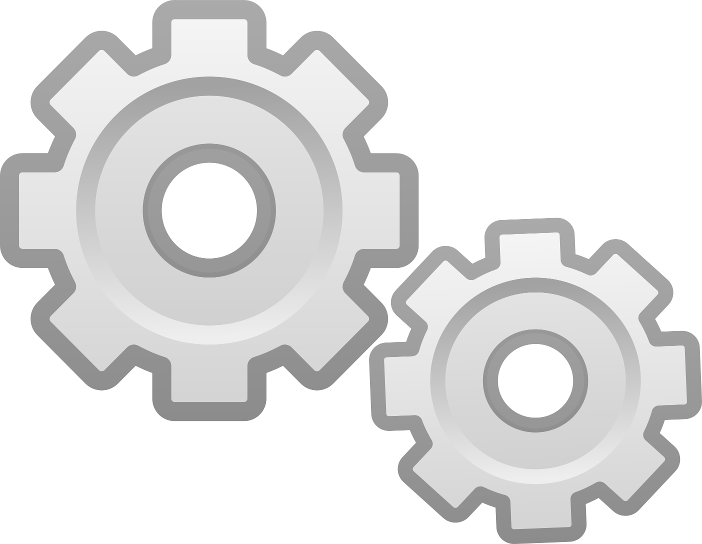

In [24]:
Image("gears.png")

### Solutions.  

#### Pingpong: C++

In [25]:
%%writefile pingpong.cc
#include <iostream>
#include <cstdlib>
#include <mpi.h>
#include <unistd.h>

using namespace std;
#define msgsz 4096

int main()
{
    int rank, size;
    const int bounces = 6;
       
    MPI::Init();
    size = MPI::COMM_WORLD.Get_size();
    
    char msg[msgsz]  = "Got ball from ";
    char rmsg [msgsz];

    for(int i = 0; i < bounces; i++)
    {
        rank = MPI::COMM_WORLD.Get_rank();
        if(rank==0 && size>1)
        {
            //C: MPI_Send(msg, msgsz, MPI_BYTE, 1, 0, MPI_COMM_WORLD)
            MPI::COMM_WORLD.Send(msg, msgsz, MPI_BYTE, 1, 0);
            
            //C: MPI_Recv(msg, msgsz, MPI_BYTE, 1, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE)
            MPI::COMM_WORLD.Recv(rmsg, msgsz, MPI_BYTE, 1, 1);            
        }
    
        if(rank==1 && size>1)
        {           
            MPI::COMM_WORLD.Recv(rmsg, msgsz, MPI_BYTE, 0, 0);
            MPI::COMM_WORLD.Send(msg, msgsz, MPI_BYTE, 0, 1);
        }
        cout << rmsg << rank << endl;
        usleep(5e5);
    }
    MPI::Finalize();
    return 0;
}

Writing pingpong.cc


In [26]:
%%bash
make pingpong opt="-O2 "

mpicxx -c -Wall -fopt-info-vec-optimized -march=native -msse4.2   -O2   pingpong.cc -o pingpong.o
mpicxx -o pingpong.exe pingpong.o -lm -lmpi -fopenmp


In [27]:
%%bash
mpirun -n 1 pingpong.exe

0
0
0
0
0
0


In [28]:
%%bash
mpirun -n 2 pingpong.exe

Got ball from 0
Got ball from 1
Got ball from 0
Got ball from 1
Got ball from 0
Got ball from 1
Got ball from 0
Got ball from 1
Got ball from 0
Got ball from 1
Got ball from 0
Got ball from 1


#### Pingpong: Fortran

In [29]:
%%writefile pingpong.f95
program pingpong
    use mpi
    implicit none

    integer :: i, rank, size, error, bounces
    character(len=14) :: msg, rmsg
    
    rank  = 0
    bounces = 6
    msg  = 'Got ball from '

    call MPI_Init(error)
    
    do 10 i = 1, bounces
    
        call MPI_Comm_rank(MPI_COMM_WORLD, rank, error)    
        call MPI_Comm_size(MPI_COMM_WORLD, size, error)  
        
        if(size.gt.1) then
            if (rank.eq.0) then
                call MPI_Send(msg, 15, MPI_BYTE, 1, 0, MPI_COMM_WORLD, error)
                call MPI_Recv(rmsg, 15, MPI_BYTE, 1, 1, MPI_COMM_WORLD, MPI_STATUS_IGNORE, error)
            endif

            if(size.gt.1.and.rank.eq.1) then
                call MPI_Recv(rmsg, 15, MPI_BYTE, 0, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE, error)
                call MPI_Send(msg, 15, MPI_BYTE, 0, 1, MPI_COMM_WORLD, error)
            endif
        endif
        write(*,*) rmsg, rank
        call EXECUTE_COMMAND_LINE('sleep 1')
    
10  continue    
    
    call MPI_Finalize(error)

end program pingpong

Overwriting pingpong.f95


In [30]:
%%bash
make f95pingpong opt="-O2 "

mpif90 -c -Wall -fopt-info-vec-optimized -march=native -msse4.2   -O2   pingpong.f95 -o pingpong.fo
mpif90 -o pingpong.exe pingpong.fo -lm -lmpi -fopenmp


In [31]:
%%bash
mpirun -n 1 pingpong.exe

 !z ÿÿ   à           0
 !z ÿÿ   à           0
 !z ÿÿ   à           0
 !z ÿÿ   à           0
 !z ÿÿ   à           0
 !z ÿÿ   à           0


In [32]:
%%bash
mpirun -n 2 pingpong.exe

 Got ball from            0
 Got ball from            1
 Got ball from            0
 Got ball from            1
 Got ball from            0
 Got ball from            1
 Got ball from            0
 Got ball from            1
 Got ball from            0
 Got ball from            1
 Got ball from            0
 Got ball from            1


#### Deadlock

In [33]:
%%writefile deadlock.cc
#include <iostream>
#include <cstdlib>
#include <mpi.h>
#include <unistd.h>

using namespace std;
#define msgsz 4096

int main()
{
    int rank, size;
    const int bounces = 6;
       
#ifdef MPI_VERSION
    MPI::Init();
    size = MPI::COMM_WORLD.Get_size();
#endif
    
    char msg[msgsz]  = "Got ball from ";
    char rmsg [msgsz];

    for(int i = 0; i < bounces; i++)
    {
#ifdef MPI_VERSION
        rank = MPI::COMM_WORLD.Get_rank();

        if(rank==0 && size>1)
        {
            MPI::COMM_WORLD.Send(msg, msgsz, MPI_BYTE, 1, 0);
            MPI::COMM_WORLD.Recv(rmsg, msgsz, MPI_BYTE, 1, 1);
        }
    
        if(rank==1 && size>1)
        {
            MPI::COMM_WORLD.Send(msg, msgsz, MPI_BYTE, 0, 1);
            MPI::COMM_WORLD.Recv(rmsg, msgsz, MPI_BYTE, 0, 0);
        }
#endif
        cout << rmsg << rank << endl;
        usleep(1e5);
    }
    
#ifdef MPI_VERSION
    MPI::Finalize();
#endif
}

Writing deadlock.cc


In [34]:
%%bash
make deadlock
mpirun -n 1 deadlock.exe

mpicxx -c -Wall -fopt-info-vec-optimized -march=native -msse4.2    deadlock.cc -o deadlock.o
mpicxx -o deadlock.exe deadlock.o -lm -lmpi
0
0
0
0
0
0


#### ring: C++

In [35]:
%%writefile ring.cc
#include <iostream>
#include <cstdlib>
#include <string>
#include <mpi.h>
#include <unistd.h>

using namespace std;

int main(int argc, char **argv)
{
    int rank, size, check, to, from;

    string hdr = ": sent to ";
    string ftr = " and received from ";
    char rmsg[35] = " xxx" ;
       
    MPI_Init(&argc,&argv);
    
    MPI_Comm_rank(MPI_COMM_WORLD,&rank);
    MPI_Comm_size(MPI_COMM_WORLD,&size);

    check = rank % size;   
    
    if (check == 0)
    {
        to   = 1;
        from = size -1;
    } 
    else if (check == size-1)
    {
        to   = 0;
        from = rank -1; 
    }
    else
    {
        to   = check + 1;
        from = check - 1; 
    }

    string msg = to_string(rank) + hdr + to_string(to) + ftr + to_string(from);
    
    if (size > 1)
    {
        MPI_Send(&msg[0],35,MPI_BYTE,to,check,MPI_COMM_WORLD);
        MPI_Recv(rmsg,35,MPI_BYTE,from,from,MPI_COMM_WORLD,MPI_STATUS_IGNORE);                
    }
    
    cout << rmsg << endl;
    
    MPI_Finalize();
}

Writing ring.cc


In [36]:
%%bash
make ring
mpirun -n 1 ring.exe

mpicxx -c -Wall -fopt-info-vec-optimized -march=native -msse4.2    ring.cc -o ring.o


ring.cc: In function 'int main(int, char**)':
ring.cc:40:32: error: 'to_string' was not declared in this scope
     string msg = to_string(rank) + hdr + to_string(to) + ftr + to_string(from);
                                ^
make: *** [ring.o] Error 1
--------------------------------------------------------------------------
mpirun was unable to launch the specified application as it could not find an executable:

Executable: ring.exe
Node: zama

while attempting to start process rank 0.
--------------------------------------------------------------------------


In [37]:
%%bash
mpirun -n 6 ring.exe

6 total processes failed to start


--------------------------------------------------------------------------
mpirun was unable to launch the specified application as it could not find an executable:

Executable: ring.exe
Node: zama

while attempting to start process rank 0.
--------------------------------------------------------------------------


#### Ring: Fortran

In [38]:
%%writefile ring.f95
program ring
    use mpi
    implicit none

    integer :: rank, error, procs, check, destination, origin
    character(len=40) :: msg, rmsg
    character(len=2) :: s0, s1, s2
    call MPI_Init(error)
    
    call MPI_Comm_rank(MPI_COMM_WORLD, rank, error)    
    call MPI_Comm_size(MPI_COMM_WORLD, procs, error)
    
    check = mod(rank,procs)
        
    if (check.eq.0) then
        destination = 1
        origin      = procs -1
    else if (check.eq.procs-1) then
        destination = 0
        origin      = rank -1
    else
        destination   = check + 1
        origin = check - 1
    endif
    
    write(s0,'(i2)') rank
    write(s1,'(i2)') destination
    write(s2,'(i2)') origin
    msg = s0 // ': sent to ' // s1 // ' and received from ' // s2
    
    if (procs.gt.1) then
        call MPI_Send(msg,40,MPI_BYTE,destination,check,MPI_COMM_WORLD,error)
        call MPI_Recv(rmsg,40,MPI_BYTE,origin,origin,MPI_COMM_WORLD,MPI_STATUS_IGNORE,error)
    endif
    
    write(*,*) rmsg
       
    call MPI_Finalize(error)

end program ring

Overwriting ring.f95


In [39]:
%%bash
make f95ring
mpirun -n 1 ring.exe

mpif90 -c -Wall -fopt-info-vec-optimized -march=native -msse4.2    ring.f95 -o ring.fo
mpif90 -o ring.exe ring.fo -lm -lmpi
@     ÅNaK          ¢¨]I          


In [40]:
%%bash
mpirun -n 8 ring.exe

  7: sent to  0 and received from  6     
  0: sent to  1 and received from  7     
  1: sent to  2 and received from  0     
  2: sent to  3 and received from  1     
  3: sent to  4 and received from  2     
  4: sent to  5 and received from  3     
  5: sent to  6 and received from  4     
  6: sent to  7 and received from  5     


<a id="three"></a>

# 3 -  Types of Communication

### Collective communications

**MPI_Send** and **MPI_Recv** are one-to-one communications. However, having always to set up messaging between all pairs is cumbersome. That's way a number of *collective communications*.

Collective communications implies a *synchronization point* among processes. This means that all processes must reach a point in their code before they can all begin executing again. This is analougous to the implicit or explicit barriers of OpenMP and, notably, there is also an `MPI_Barrier`:

    MPI_Barrier(MPI_Comm communicator);

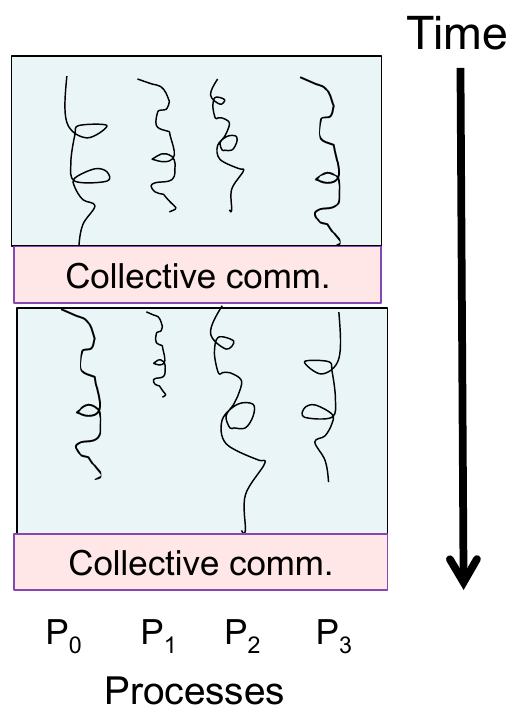

In [41]:
Image("barrier.png")

**Broadcast**: one process sends the same data to all processes in a communicator. One of the main uses of broadcasting is to send out user input to a parallel program (`MPI_Init(&argc, &argv)`, or send out configuration parameters to all processes.

    int MPI_Bcast( void *buffer, int count, MPI_Datatype datatype,
     int root, MPI_Comm comm );

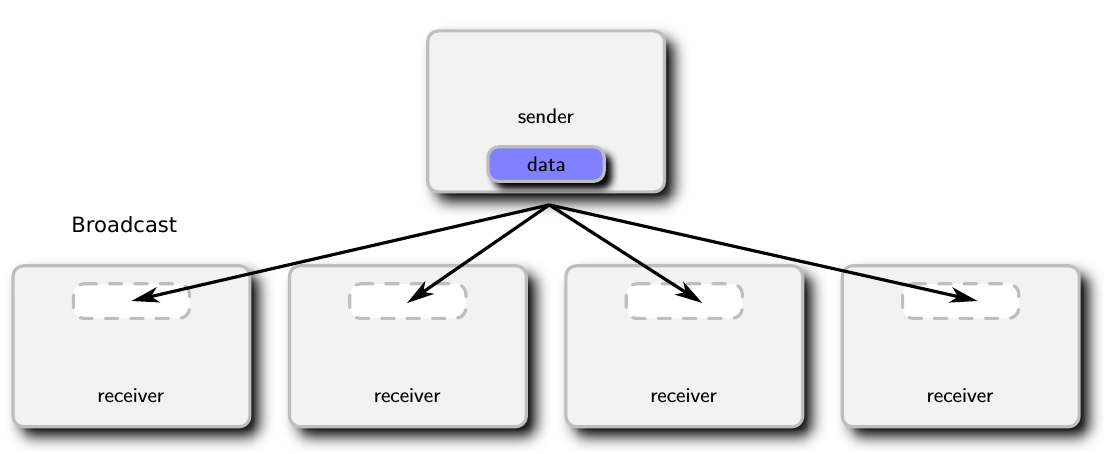

In [42]:
Image("bcast.png")

**MPI_Scatter** MPI_Scatter sends **chunks of an array** from a root rank to others. This is different from **MPI_Bcast** which send *the same piece of information to everybody*. 

     int MPI_Scatter(void *sendbuf, int sendcnt, MPI_Datatype sendtype, void  int recvcnt,   
        MPI_Datatype *recvtype,  int root, MPI_Comm comm);

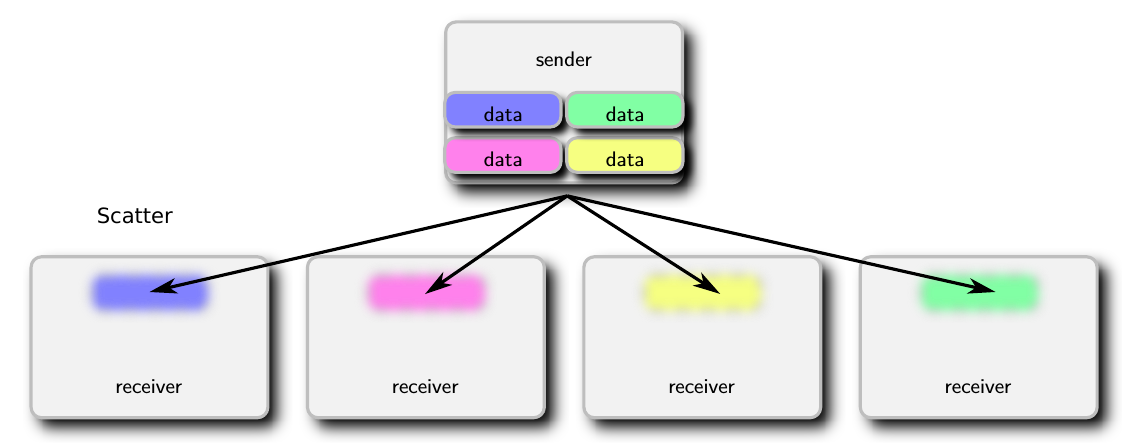

In [43]:
Image("scatter.png")

**MPI_Gather** is the reverse of **MPI_Scatter**: instead of spreading elements from one process to many processes, it gathers widespread information to the buffer of the root process. 

     int MPI_Gather(void *sendbuf, int sendcnt, MPI_Datatype sendtype,
      void *recvbuf, int recvcnt, MPI_Datatype recvtype, int root, MPI_Comm comm)

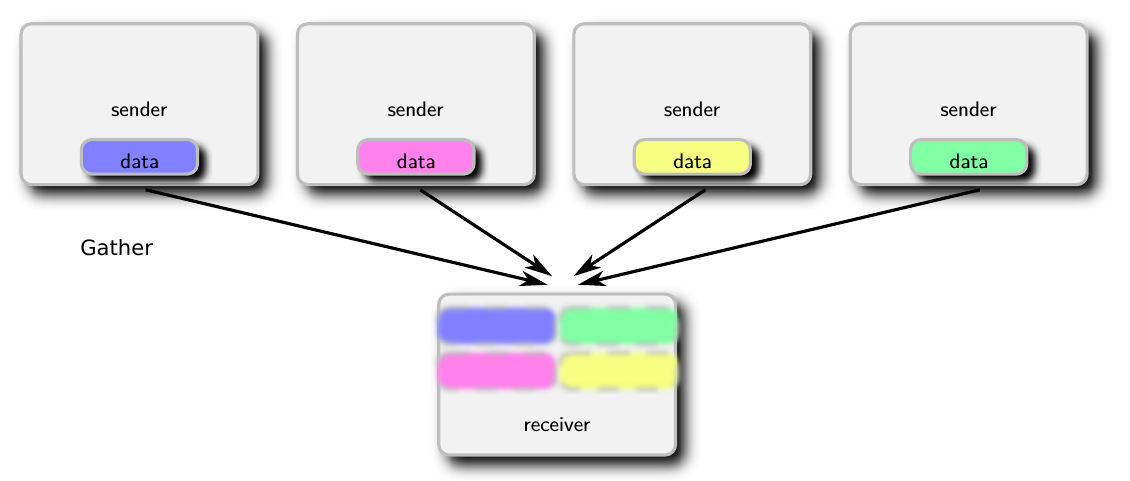

In [44]:
Image("gather.png")

There is also a function for the ubiquitous *reduction* operation:

     int MPI_Reduce(void *sendbuf, void *recvbuf, int count, MPI_Datatype datatype,
        MPI_Op op, int root, MPI_Comm comm);

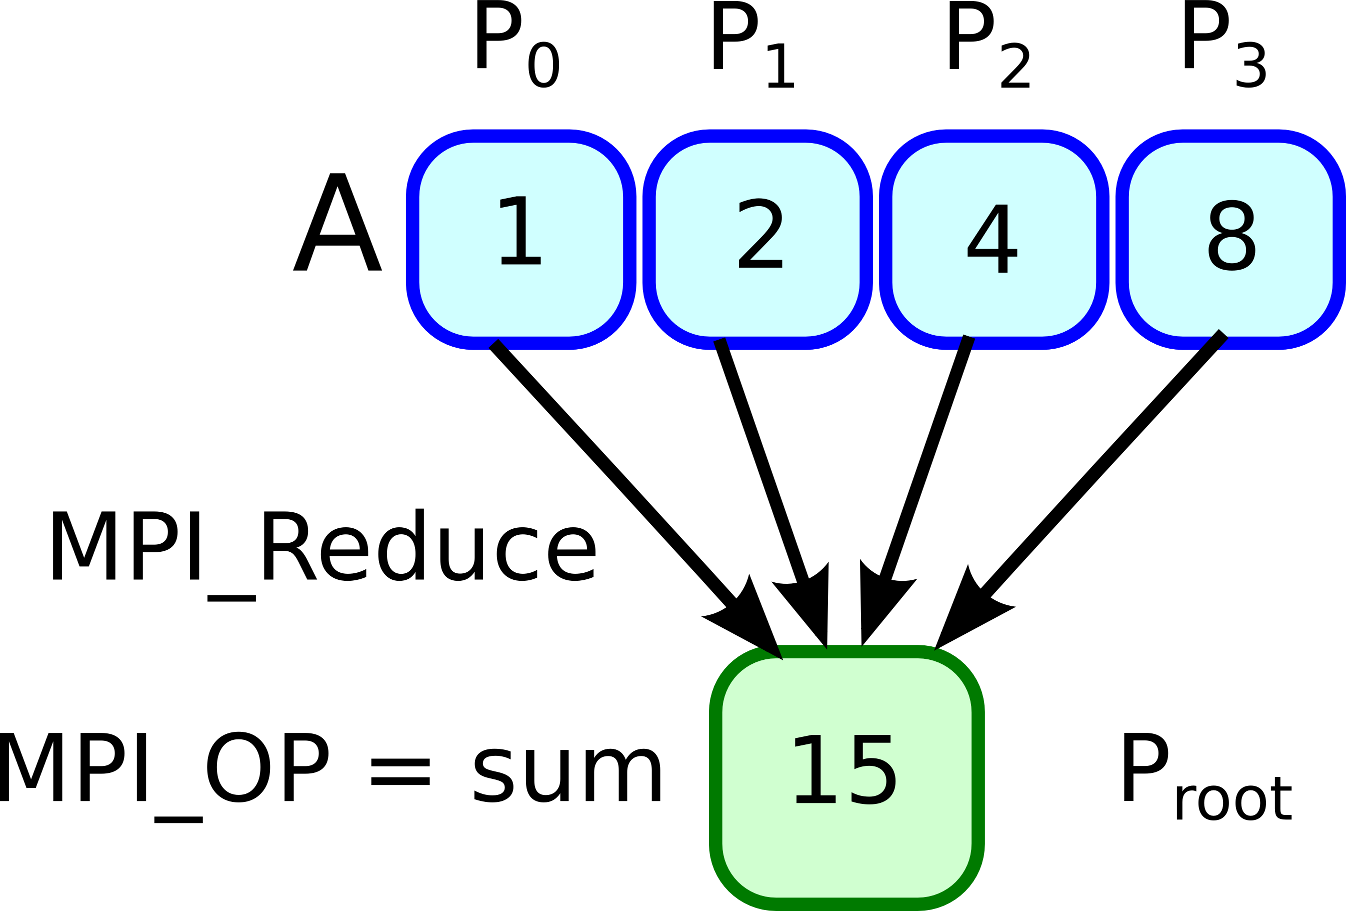

In [45]:
Image("reduction.png")

**MPI_Scan** can be considered the inverse of **MPI_Reduce**:

    int MPI_Scan(void* sendbuf, void* recvbuf, int count, MPI_Datatype datatype, MPI_Op op, MPI_Comm comm ) 

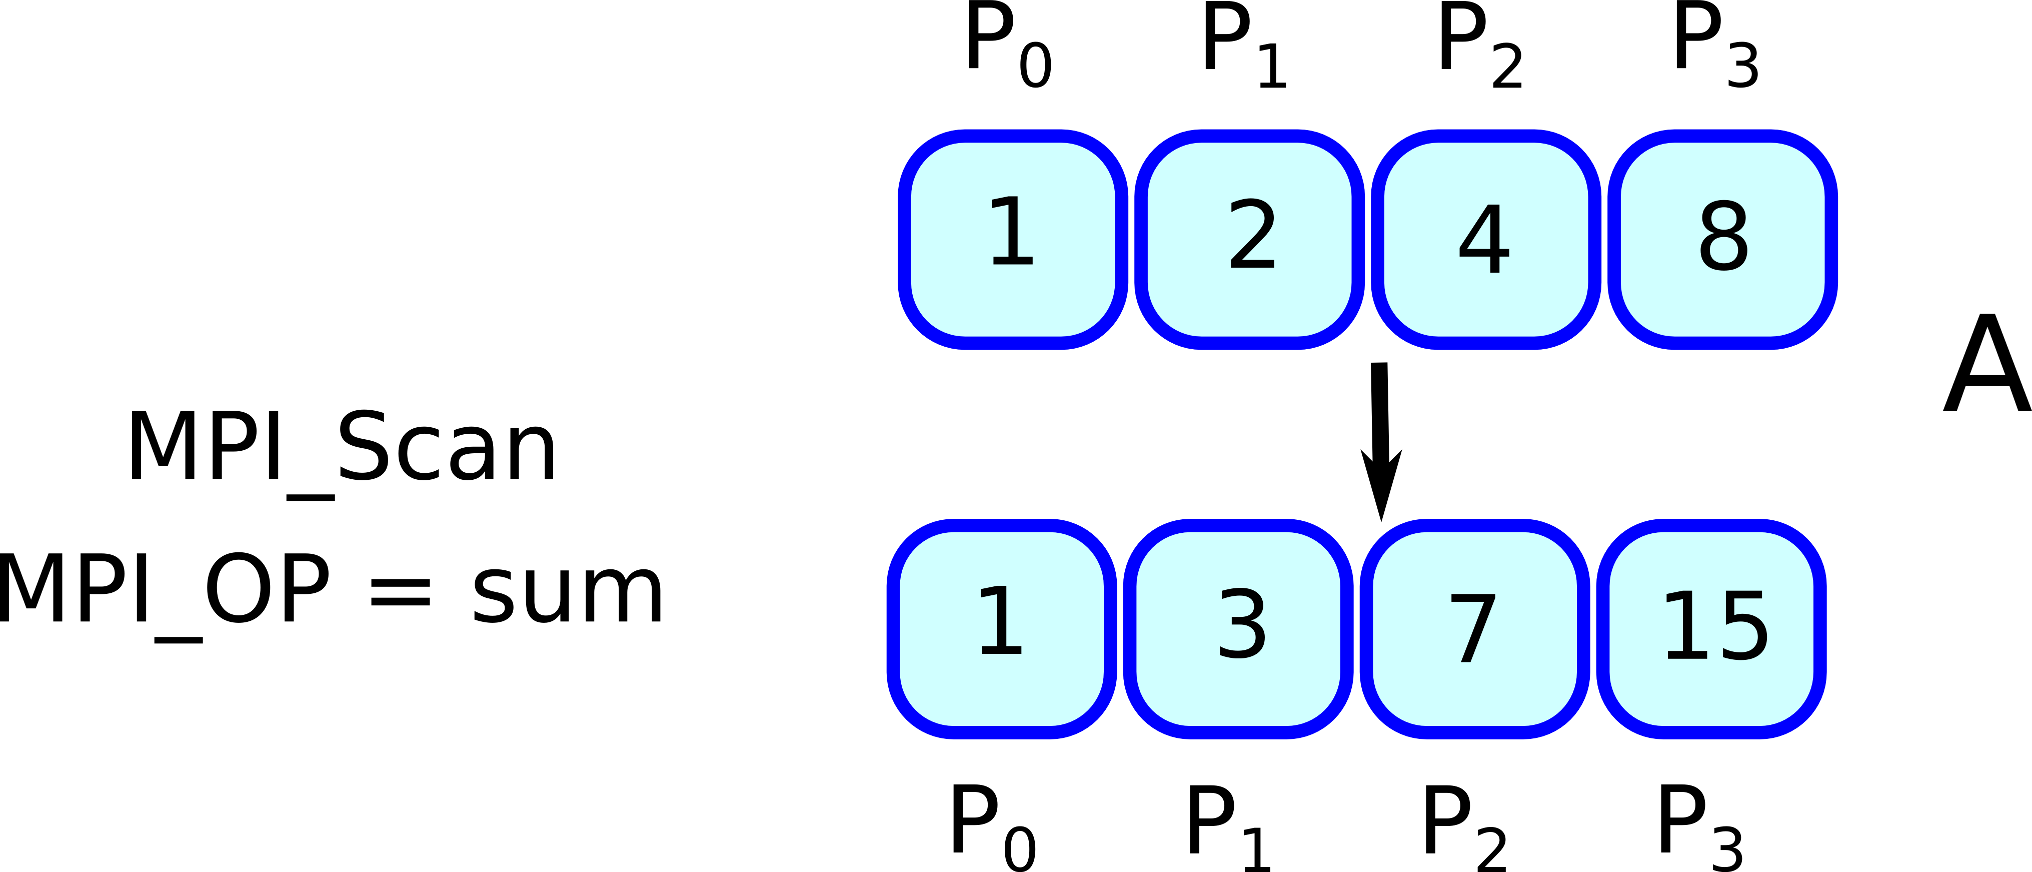

In [46]:
Image("scan.png")

Available reducers:

|Name | type
|-----| -----
|MPI_MAX |maximum 
|MPI_MIN |minimum 
|MPI_SUM |sum 
|MPI_PROD |product 
|MPI_LAND |logical and 
|MPI_BAND |bit-wise and 
|MPI_LOR |logical or 
|MPI_BOR |bit-wise or 
|MPI_LXOR |logical xor 
|MPI_BXOR |bit-wise xor 
|MPI_MAXLOC |max value and location 
|MPI_MINLOC | min value and location 

And there are also **all-to-all** communications:

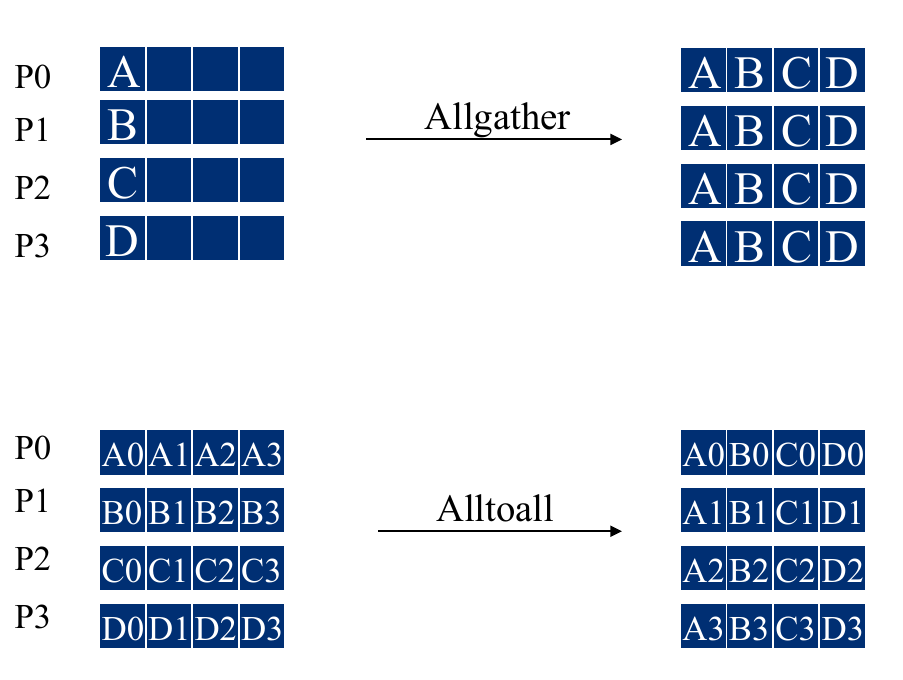

In [47]:
Image("all_to_all.png")

    MPI_Allgather(void* send_data, int send_count, MPI_Datatype send_datatype, void* recv_data,
        int recv_count, MPI_Datatype recv_datatype, MPI_Comm communicator)

### Non blocking communications

One can improve performance on many systems by *overlapping communication and computation*. 
A *nonblocking send* starts initiates the send operation, *but does not complete it*, returning *before the message copy is completed*.  
A *nonblocking receive* initiates the receive operation but returns storing the complete message.

    int MPI_Isend(void *buffer, int count, MPI_Datatype datatype, int dest, 
        int tag, MPI_Communicator comm, MPI_Request *request);
        
    int MPI_Irecv(void *buffer, int count, MPI_Datatype datatype, int source, int tag,
        MPI_Communicator comm, MPI_Request *request);

`MPI_Request` takes the role of `MPI_Status` in the blocking Recv but now is needed also by the send call.

Completition of the request is made with `MPI_Test`: 
    
    int MPI_Test(MPI_Request *request, int *flag, MPI_Status *status);

**ISend/Test** is then equivalent to **Send**.

testing can be delayed with **MPI_Wait()**:
    
    int MPI_Wait(MPI_Request *request, MPI_Status *status);

## Part 3: Exercises

**1**: you guess it ... numerical integration:

$$ I = \int_0^a f(x)dx \approx \sum_{i=0}^{n-1} f(x_{i+\frac{1}{2}})\Delta x $$
where
$$ \Delta x=\frac{a}{n}, x_{i+\frac{1}{2}} = (i+\frac{1}{2}) \Delta x $$

try to write an MPI version. Don't worry (too much) about performance.

**2**: [Jacobi solver](#http://mathworld.wolfram.com/JacobiMethod.html): given a [diagonally dominant matrix](#https://en.wikipedia.org/wiki/Diagonally_dominant_matrix) **A** and a vector **b**, solve:

$$ Ax = b $$

by iterating:

$$ x_i^{(k+1)} = \frac {b_i - \sum_{i \ne j} A_{ij} x_j^{(k)} } {A_{ii}} $$.

Create a random matrix **A** such as that $A_{ii} >= 2.*\sum_{j \ne i} A_{j}$ and a random vector **b**; then implement the Jacobi and try to use MPI:

You can test that the algorithm converges by calculating every (nth) step:

$$ conv = \sum_i (x_i^{(k+1)} - x_i^{(k)})^2 $$

and comparing against a preset tolerance; also you may test if it yields the correct result at the end of the loop by computing the error as:

$$ err_i = b_i - \sum_{j} A_{ij} $$

and

$$ err = \frac {\sqrt {\sum_i err_i^2}} {n} $$

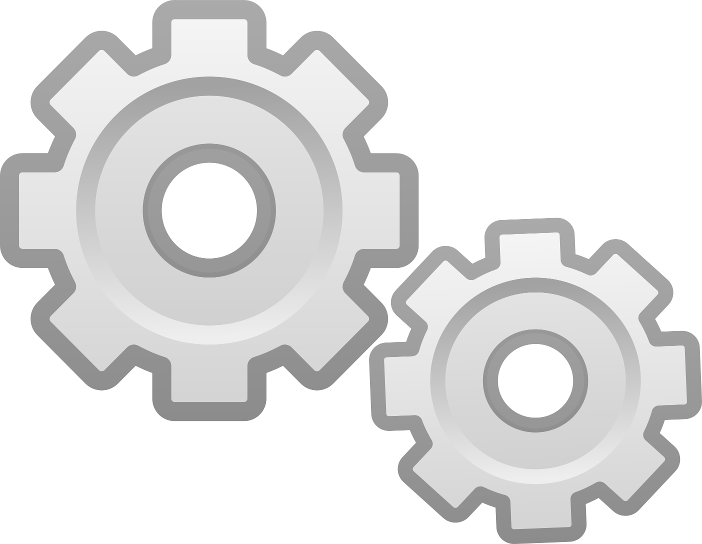

In [48]:
Image("gears.png")

**Hints**: serial versions of Jacobi in C and F95:

In [49]:
%%writefile jacobi.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
#include <math.h>
#include <time.h>

double check_jacobi(int dim, double *A, double *b, double *xnew)
{
    double sum = 0.;
    for(int i = 0; i < dim; i++)    
    {
        double sum_i = b[i];
        for(int j = 0; j < dim; j++)    
            sum_i -= A[i + j*dim] * xnew[j];
        sum += pow(sum_i,2);
    }
    
    return sqrt(sum/(double ) dim);
}


double jacobi(int dim, double *A, double *b, double *xold, double *xnew, double tol, int kmax, int *niter)
{
    int k = 0;
    double conv = (double ) kmax;
    double tmp; 

    while(k < kmax && conv > tol)
    {
        conv = 0. ;
        for(int i = 0; i < dim; i++)
        {
            tmp = 0.;
            for(int j = 0; j < dim; j++)            
            {
                if (i==j) continue;                
                tmp += xold[j] * A[i + j*dim];
            }
            xnew[i] = (b[i] - tmp)/A[i + i*dim];
            conv += pow((xnew[i]-xold[i]),2);
        }
        for(int i = 0; i < dim; i++)
            xold[i] = xnew[i];
        k++;
    }
    
    *niter = k;
    return conv;
}

int main(int argc, char **argv)
{
    //argv1 DIM argv2 high
    double tol = 1e-8;
    int kmax = 100;
    int DIM  = atoi(argv[1]);
    int high = atoi(argv[2]);
    int niter;
    srand(time(0));
    
    //allocate
    double *A  = malloc(DIM * DIM * sizeof(double));   
    double *b  = malloc(DIM * sizeof(double));
    double *xo = malloc(DIM * sizeof(double));
    double *xn = calloc(DIM, sizeof(double));

    //generate A and b and make A diagonally dominant
    for (int i=0; i < DIM;i++)
    {
        b[i]  = (double ) (rand() % high);
        xo[i] = (double ) (rand() % high);
        double sum = 0.;
        for (int j=0; j< DIM; j++)
        {
            if (i==j) continue;
            A[i + j*DIM] = (double ) (rand() % high);
            sum += A[i + j*DIM];
        }
        A[i + i*DIM] = 1.5 * sum;
    }
    
    //call jacobi
    double t0 = omp_get_wtime();
    double conv = jacobi(DIM, A, b, xo, xn, tol, kmax, &niter);
    if(niter < kmax)
        printf("converged at %g after %d iterations in %g s\n",conv,niter,omp_get_wtime()-t0);
    else
        printf("NOT converged (tol=%g) after %d iterations\n",conv,niter);
    
    //check results
    double error = check_jacobi(DIM, A, b, xn);
    printf("error=%f\n",error);
   
}

Writing jacobi.c


In [50]:
%%bash
make jacobi opt="-O2"
OMP_NUM_THREADS=1 ./jacobi.exe 1000 100

mpicc -std=c99 -c -Wall -fopt-info-vec-optimized -march=native -msse4.2   -O2  jacobi.c -o jacobi.o
mpicc -std=c99 -o jacobi.exe jacobi.o -lm -lmpi -fopenmp
converged at 4.56466e-09 after 44 iterations in 0.0738438 s
error=0.105654


In [51]:
%%writefile f95jacobi.f95 
 module fjac
 contains
 subroutine jacsolv(kmax,A,b,xold,conv,xnew,order)
 implicit none

 integer :: order
 real(8), dimension(0:order-1,0:order-1) :: A
 real(8), dimension(0:order-1) :: xold,b
 real(8), dimension(0:order-1) :: xnew
 !f2py intent(in)    order
 !f2py intent(out)   xnew
 !f2py depend(order) xnew
 
 integer :: i, k, kmax
 !f2py intent(in,out) kmax
 real(8) :: conv, tol
 !f2py intent(out) conv
 real(8), dimension(0:order-1) :: dd, xtmp
 real(8), dimension(0:order-1, 0:order-1) :: R, D

 conv  = kmax
 tol   = 1e-8

 xtmp = xold
 xnew = 1.
 forall (i=0:size(dd)-1) D(i,i) = A(i,i)
 forall (i=0:size(dd)-1) dd(i)   = 1./A(i,i)
 R = A-D

 do k=1,kmax
     conv = 0.
     do i = 0,order-1
         xnew(i) = (b(i) - DOT_PRODUCT(xtmp,R(i,:)) )*dd(i)
     end do
     conv = SUM((xnew-xtmp)*(xnew-xtmp))

     if (conv <= tol) then
         exit
     end if

     xtmp = xnew

 end do
 
 kmax = k
 
 end subroutine
 end module fjac

Overwriting f95jacobi.f95


### Solutions

#### Integral

In [52]:
%%writefile integral.cc
#include <iostream>
#include <cstdlib>
#include <mpi.h>
#include <omp.h>

using namespace std;

double eval_func(double a, double dx, int first, int last)
{
    double I = 0.;
    
    #pragma omp simd reduction(+:I)
    for(int i = first; i < last; i++)
    {
        double x = a + dx * ((double ) i + 0.5);
        I += 4./(1. + x*x);
    }
    return I;
}

int main(int argc, char **argv)
{
    
    int num_steps = argv[1] != NULL ? atoi(argv[1]) : 1E8;
    double t0, t1;
    double start = 0.;
    double end   = 1.;
    
    int rank = 0;
    t0 = MPI_Wtime();

    int size;
    MPI::Init(argc, argv);
    rank = MPI::COMM_WORLD.Get_rank();
    size = MPI::COMM_WORLD.Get_size();
    
    double PI = 0.;
    double dx = (end-start) / ((double ) num_steps);
    
    double I = eval_func(start, dx, rank*num_steps/size, (rank+1)*num_steps/size);
    
    MPI::COMM_WORLD.Reduce(&I, &PI, 1, MPI_DOUBLE, MPI_SUM, 0);    
    MPI::Finalize();

    if(rank == 0)
    {
        if(num_steps % size != 0)
        {
            
        }
        PI = (PI)*dx;
        t1 = MPI_Wtime();
        cout  << "Loop completed in "<< 1000.*(t1-t0) << " ms" << endl;
        cout  << "Integral value = " << PI << endl;
    }
}

Writing integral.cc


In [53]:
%%bash
make integral opt="-O2 -fopenmp-simd"
mpirun -n 4 integral.exe

mpicxx -c -Wall -fopt-info-vec-optimized -march=native -msse4.2   -O2 -fopenmp-simd  integral.cc -o integral.o
4 total processes failed to start


g++: error: unrecognized command line option '-fopenmp-simd'
make: *** [integral.o] Error 1
--------------------------------------------------------------------------
mpirun was unable to launch the specified application as it could not find an executable:

Executable: integral.exe
Node: zama

while attempting to start process rank 0.
--------------------------------------------------------------------------


#### Jacobi

In [54]:
%%writefile jacobi.c
#include <stdlib.h>
#include <stdio.h>
#include <math.h>
#include <mpi.h>
#include <string.h>

double check_jacobi(int dim, double **A, double *b, double *xnew)
{
    double sum = 0.;
    
    for(int i = 0; i < dim; i++)    
    {
        double sum_i = b[i];
        
        for(int j = 0; j < dim; j++)    
            sum_i -= A[i][j] * xnew[j];
        
        sum += pow(sum_i,2);
    }
    
    return sqrt(sum/(double ) dim);
}

void gen_jac_input(int DIM, int high, double **A, double *b, double *xo)
{

    for (int i=0; i < DIM;i++)
    {
        b[i]  = (double ) (rand() % high);
        xo[i] = (double ) (rand() % high);
        double sum = 0.;

        for (int j=0; j< DIM; j++)
        {
            A[i][j] = (double ) (rand() % high);
            sum += A[i][j];
        }
        A[i][i] = 1.5 * (sum - A[i][i]);
    }
}

double do_iter(int rank, int first, int last, int dim, \
               double **A, double *b, double *xold, double *xnew)
{
        double conv = 0.;
        for(int i = first; i < last; i++)
        {
            double tmp = 0.;
            int row = i + rank*last;
            
            #pragma omp simd reduction(+:tmp)
            for(int j = 0; j < dim; j++)
                tmp += xold[j] * A[row][j];

            xnew[i] = (b[row] - tmp + xold[row] * A[row][row])/A[row][row];
            conv += pow(xnew[i]-xold[row],2);
        }    
        return conv;
}

double jacobi(int dim, double **A, double *b, double *xold,\
    double *xnew, double tol, int kmax, int *niter)
{

    int rank, size;
#ifdef MPI_VERSION    
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);
#else
    rank = 0;
    size = 1;  
#endif    
    
    double gconv = 1. + tol;
    int chunk = dim / size;
    int k = 0;
    
    while(k < kmax && gconv > tol)
    {
        
        double conv = do_iter(rank, 0, chunk, dim, A, b, xold, xnew);
#ifdef MPI_VERSION                           
        if(rank == 0 && dim % size > 0)
        {
            conv += do_iter(0, size*chunk, dim, dim, A, b, xold, xnew);
            for(int i = size*chunk; i < dim; i++)
                xold[i] = xnew[i];
        }
        MPI_Allgather(xnew, chunk, MPI_DOUBLE, xold, chunk, MPI_DOUBLE,
            MPI_COMM_WORLD);

        if(dim % size > 0)
            MPI_Bcast(&xold[size*chunk], dim % size, MPI_DOUBLE, 0, MPI_COMM_WORLD);      
        MPI_Allreduce(&conv, &gconv, 1, MPI_DOUBLE, MPI_SUM, MPI_COMM_WORLD);
#else
        gconv = conv;
#endif        
        k++;
    }
    
    memcpy(xnew,xold,sizeof(double) * dim);
    *niter = k;
    return gconv;
}

int main(int argc, char **argv)
{
    double tol = 1e-8;
    const int kmax = 100;
    const int DIM  = atoi(argv[1]);
    const int high = atoi(argv[2]);
    int niter;
    
    double t0 = 0., t1 = 0.;
    srand(23);
    
    //allocate
    double  **A = malloc(DIM * sizeof(double*));
    A[0] =  malloc(DIM * DIM * sizeof(double));
    for(int i = 1; i < DIM; i++)
        A[i] = A[0] + i*DIM;
    double  *b = malloc(DIM * sizeof(double));
    double *xo = malloc(DIM * sizeof(double));
    double *xn = calloc(DIM, sizeof(double));

    //generate A and b and make A diagonally dominant
    gen_jac_input(DIM, high, A, b, xo);
    
    int rank = 0;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    
    //call jacobi 
    t0 = MPI_Wtime();

    double conv = jacobi(DIM, A, b, xo, xn, tol, kmax, &niter);
      
    MPI_Finalize();
    t1 = MPI_Wtime();
    
    if(rank == 0)
    {
        if(niter < kmax)
            printf("converged at %g after %d iterations in %g s\n",conv,niter,t1-t0);
        else 
            printf("NOT converged (conv=%g) after %d iterations\n",conv,niter);
        
        //check results
        double error = check_jacobi(DIM, A, b, xn);
        printf("error=%f\n",error);
    }
   
}

Overwriting jacobi.c


In [55]:
%%bash
source /usr/local/bin/gcc_vars.sh
make jacobi opt="-O2 -fopenmp-simd"
mpirun -n 1 jacobi.exe 4000 100

mpicc -std=c99 -c -Wall -fopt-info-vec-optimized -march=native -msse4.2   -O2 -fopenmp-simd  jacobi.c -o jacobi.o
mpicc -std=c99 -o jacobi.exe jacobi.o -lm -lmpi -fopenmp
converged at 8.85065e-09 after 45 iterations in 0.63143 s
error=0.294429


jacobi.c:53:28: note: loop vectorized


In [56]:
%%bash
mpirun -n 4 jacobi.exe 4000 100

converged at 8.85065e-09 after 45 iterations in 0.301642 s
error=0.294429


<a id="four"></a>

# 4 - Parallell programming design patterns

**Design Patterns** - Qualitative description of a frequently occurring problem in some domain and its solution
- (object oriented programming, network apps...)

Description usually involves problem definition, driving forces, solution, benefits, difficulties, related
patterns.

**Pattern Language** - a collection of design patterns, guiding the users through the decision process in building a system.

A *very* famous [book](#https://en.wikipedia.org/wiki/Design_Patterns) on this topic.

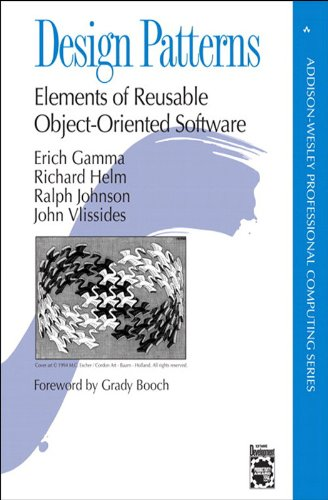

In [57]:
Image("Design_Patterns_cover.jpg")

**Example: last man on earth pattern**

Definition:  
- we are alone and need resource (see [here](#https://www.goodreads.com/book/show/14064.I_Am_Legend)).  
- must account for all chances.  

Driving Forces:
- appetite, warm, light  

Solution
- find resources
- find way to tranport

Benefits
- may find a cure

Difficulties
- overcome lazyness or despair

Related Patterns
- train for endurance, speed, explosive usage.

**Survival pattern language**

1. Wakeup
2. Check safety?
3. Go outside and kill vampires?
4. Do experiments?

A [beautiful book](#https://www.amazon.com/Patterns-Parallel-Programming-paperback-Software/dp/0321940784) on parallel programming patterns:

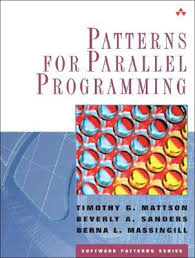

In [58]:
Image("pplp.jpeg")

- Parallel is hard and seldom exploits full hardware capabilities.
- A “cookbook” illustrating common problems and solutions would be handy (loop centric, divide and conquer ...)
- Provide a common vocabulary (factory pattern).
- Improve software reusability.

Flowchart:

- FindingConcurrency
    - data vs. control
- AlgorithmStructure
    - pipeline, replicate...
- SupportingStructure
    - SPMD, fork/join...
- Implementation
    - barriers, locks...

Common patterns:

- Embarassingly Parallel (Mandelbrot set)
- Replicable (Integral)
- Repository
- Divide and Conquer (Fibonacci with recursion)
- Pipeline
- Recursive Data
- Geometric
- IrregularMesh
- Inseparable

The geometric decomposition pattern: Dependencies exist, but communicate in predictable (geometric) neighbor-to-neighbor paths

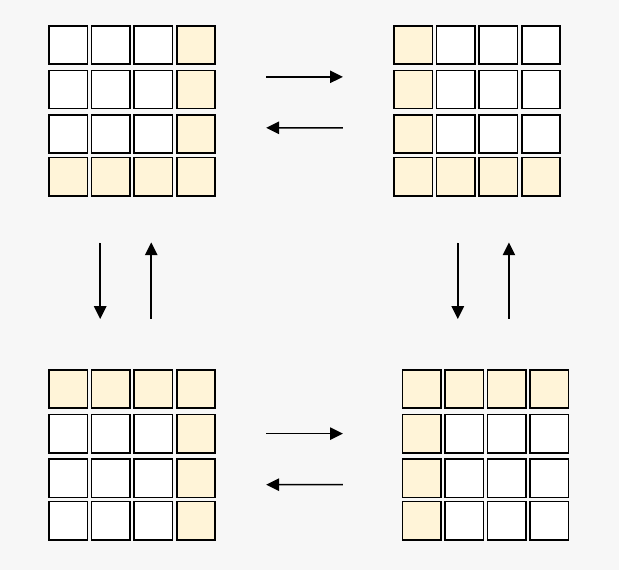

In [59]:
Image("geom_decomp.png")

Neighbor-To-Neighbor communication.  
Examples: Molecular Dynamics, Finite differences.

Molecular Dynamics:

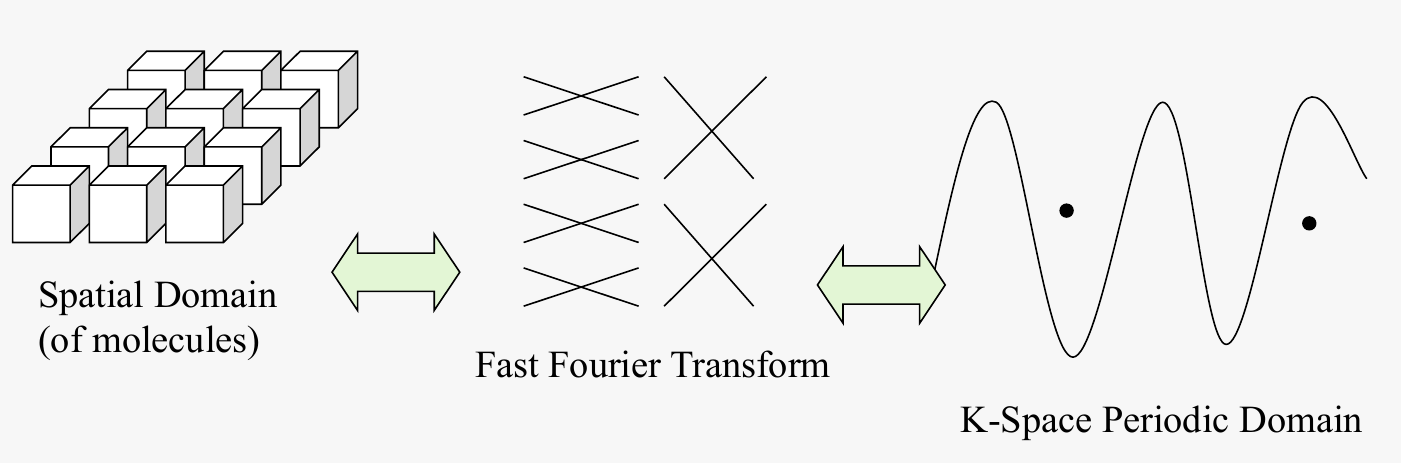

In [60]:
Image("pme.png")

**Example: 1D finite differences**

Solve the heat diffusion equation in infinitely thin rod:

$$ \frac{\partial^2 T}{\partial x^2} = \frac{\partial T}{\partial t} $$

- $T(x,t)$ describes the temperature field.  
- Boundary conditions: infinite heat reservoir at endpoints.  
- Initial conditions: zero in all other points.

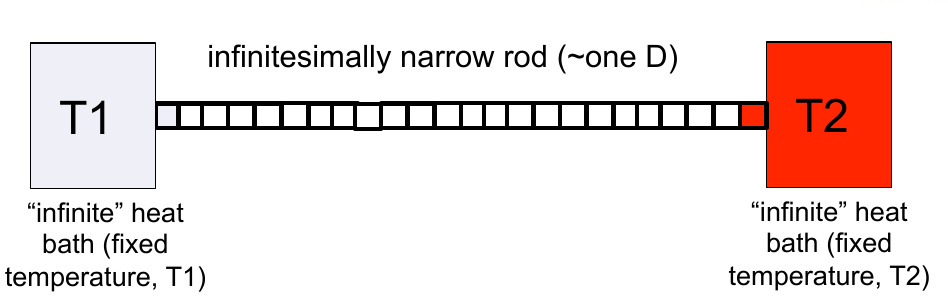

In [61]:
Image("rod.png")

Use first order and second order finite difference for time and space, respectively:

$$ \frac{\partial T}{\partial t}  = \frac{T^{n+1}-T^n}{\delta t} $$
$$ \frac{\partial^2 T}{\partial x^2}  = \frac{T_{j+1}-2.\cdot T_j+T_{j-1}}{\delta x} $$

then combine:

$$ T^{n+1}_j = T^{n}_j - r\cdot (T^{n}_{j+1} -2.\cdot T^n_j+T^n_{j-1} ) $$

where $$ r = \frac{\delta t}{{\delta x}^2} $$ must be less than 0.5 to converge.

    for	(int t = 0;	t <	N_STEPS‐1;	t++)	
        for	(int x = 1;	t <	N_POINTS-1;	x++)	
            u[t+1][x] =	u[t][x]	+r*(u[t][x+1]- 2*u[t][x]+u[t][x-1]);	

Solve using a three point "stencil".

In [62]:
%%writefile heat_serial.cc
#include <iostream>
#include <fstream>
#include <new>

using namespace std;

int main()
{
    double H0 = 100., H1 = 100.;   //temperature at boundaries

    int Ncell = 5e2; //number of cells along x
    int Nstep = 1e6; //number of time steps
    
    double delta_t, delta_x, scalef; // spacing in time and space
    delta_t = 1. / ((double ) Nstep);
    delta_x = 1. / ((double ) Ncell);
    scalef = delta_t / (delta_x * delta_x);
    
    double *Temp, *Tnew, *swap;
    Temp = new double [Ncell]; // set array to zero
    Tnew = new double [Ncell]; // alg. does not involve middle time steps
    
    Temp[0] = H0;
    Temp[Ncell-1] = H1;
    Tnew[0] = H0;
    Tnew[Ncell-1] = H1;
    
    for(int time = 0; time < Nstep; time++)     // loop on time steps
    {
        //apply stencil
        #pragma omp simd
        for(int cell = 1; cell < Ncell-1; cell++) // loop on spatial domain
            // central 2nd ord finite difference
            Tnew[cell] = Temp[cell] + scalef * (Temp[cell+1] - 2.*Temp[cell] + Temp[cell-1]);
        
        //avoid to use array buffer
        swap = Tnew;
        Tnew = Temp;
        Temp = swap;
    }
    
    ofstream outfile;
    outfile.open ("temp_field.dat");
    for(int i=1; i < Ncell-1; i++)
        outfile << i << " " << Tnew[i] << endl;
    outfile.close();
    return 0;
}

Writing heat_serial.cc


In [63]:
%%bash
source /usr/local/bin/gcc_vars.sh
make heat_serial "opt=-O2 -fopenmp-simd"
./heat_serial.exe
tail -2 temp_field.dat

mpicxx -c -Wall -fopt-info-vec-optimized -march=native -msse4.2   -O2 -fopenmp-simd  heat_serial.cc -o heat_serial.o
g++  -o heat_serial.exe heat_serial.o -lm -lmpi -fopenmp
497 99.9999
498 100


heat_serial.cc:34:35: note: loop vectorized


How to parallelise this?   
Answer: *Geometric Decomposition pattern*:  Break it into chunks assigning one chunk to each process.  
Problem: end of chunk cells depend on each other across processes.  
Solution: use *ghost cells* to replicate data between processes.  

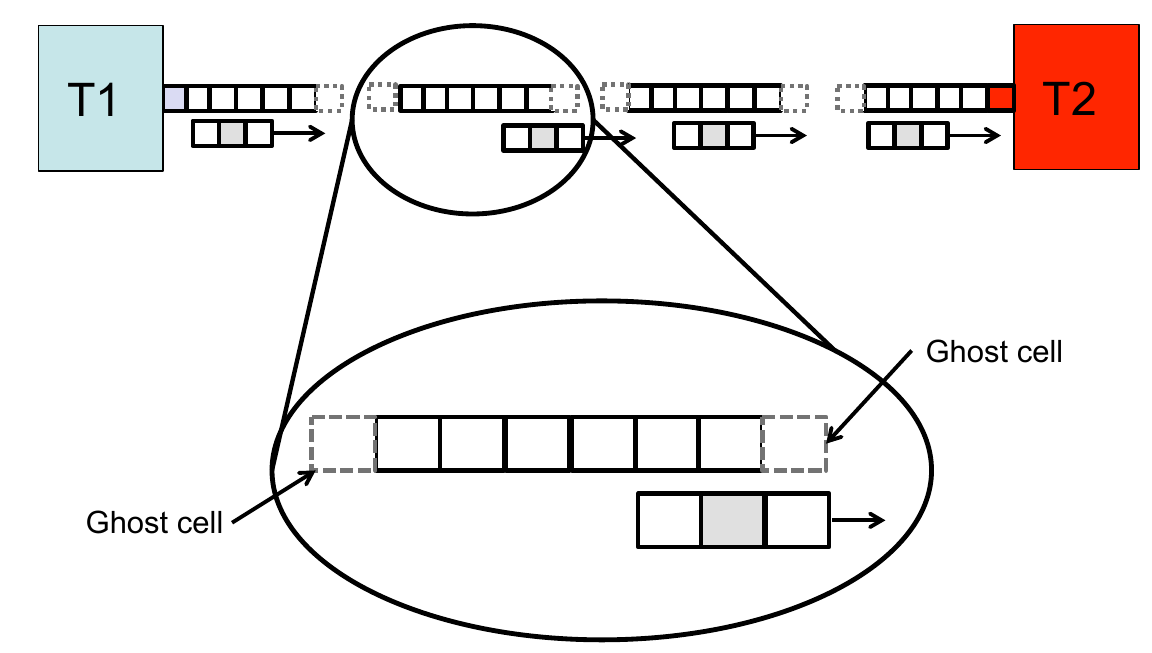

In [64]:
Image("ghost.png")

### Part 4: Exercise

Implement a geometric decomposition pattern version of `heat.cc`.

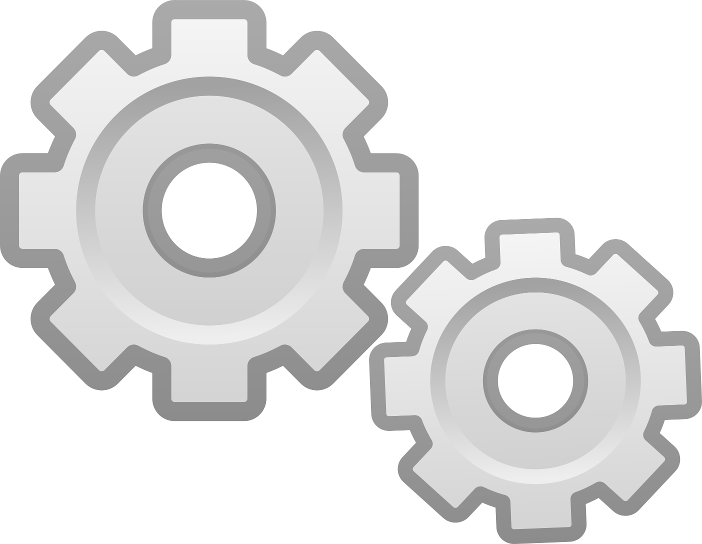

In [65]:
Image("gears.png")

#### Solution

In [66]:
%%writefile heat.c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <mpi.h>

int main()
{
    double H0 = 100., H1 = 100.; 

    int Ncell = 5e2; 
    int Nstep = 1e6; 
    
    double delta_t, delta_x, scalef;
    double *Temp, *Tnew, *swap;    
    
    int rank, size, chunk, first, last;
    
    MPI_Init(0,NULL);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);
    MPI_Status status;
    
    if (size > 1)
    {   
        if(Ncell % size != 0)
            Ncell = size * (Ncell % size + Ncell / size);            
        chunk = Ncell / size + 2;
        first = 2;
        last  = chunk-2; 
        Temp = calloc(chunk, sizeof(double));
        Tnew = calloc(chunk, sizeof(double));

        if(rank == 0)
            Temp[1] = H0;
        if(rank == size-1)
            Temp[chunk-2] = H1;
    } 
    else
    {
        first = 1;
        last  = Ncell - 1;
        chunk = Ncell;
        
        Temp = calloc(Ncell, sizeof(double));
        Tnew = calloc(Ncell, sizeof(double));        
        Temp[0] = H0;
        Temp[Ncell-1] = H1;        
    }
    
    for(int i = first-1; i <= last+1; i++)
        Tnew[i] = Temp[i];
    
    delta_x = 1. / ((double ) Ncell);
    delta_t = 1. / ((double ) Nstep);
    scalef = delta_t / (delta_x * delta_x);    
    
    if(rank == 0) 
        printf("scalef, Ncell, chunk: %f %d %d \n",scalef,Ncell,chunk);
   
    for(int time = 0; time < Nstep; time++) 
    {   
       if (size > 1)
       {
           // has a left neighbour
            if(rank != 0) 
                MPI_Send(&Temp[1], 1, MPI_DOUBLE, rank-1, rank, MPI_COMM_WORLD);
       
            // has a right neighbour
            if(rank != size - 1) 
            {
                MPI_Recv(&Temp[last+1], 1, MPI_DOUBLE, rank+1, rank+1, MPI_COMM_WORLD, &status);
                MPI_Send(&Temp[last], 1, MPI_DOUBLE, rank+1, rank, MPI_COMM_WORLD);
            }
       
            if(rank != 0) 
                MPI_Recv(&Temp[0], 1, MPI_DOUBLE, rank-1, rank-1, MPI_COMM_WORLD, &status);
       } //endif size > 1

        //apply stencil
        #pragma omp simd
        for(int cell = first; cell < last; cell++) 
            Tnew[cell] = Temp[cell] + scalef * (Temp[cell+1] - 2.*Temp[cell] + Temp[cell-1]);
        
        if(size > 1)
        {
            // 0 is a ghost cell
            if(rank != 0)
                Tnew[1] = Temp[1] + scalef * (Temp[2] - 2.*Temp[1] + Temp[0]);
                
            // chunk+2-1 is a ghost cell
            if(rank != size - 1)
                Tnew[last] = Temp[last] + scalef * (Temp[last+1] - 2.*Temp[last] + Temp[last-1]);
        }
        
        swap = Tnew;
        Tnew = Temp;
        Temp = swap;
        
    } //end for time
    
    if (size > 1)
    {
        swap = calloc(Ncell, sizeof(double)); 
        MPI_Allgather(&Tnew[1],last,MPI_DOUBLE,swap,last,MPI_DOUBLE,MPI_COMM_WORLD);
    }

    MPI_Finalize();

    if (rank == 0) 
    {
        char outname[30] = "temp_field_np_";
	char SZ[10];
	sprintf(SZ,"%d",size);
	strcat(outname, SZ);

	FILE *fp = fopen(outname, "w");
        for(int i = 1; i < Ncell; i++)
            fprintf(fp,"%d %f\n", i, swap[i]); 
	fclose(fp);
    }
    return 0;
}

Writing heat.c


In [67]:
%%bash
source /usr/local/bin/gcc_vars.sh
make heat opt="-O2 -fopenmp-simd"
mpirun -n 2 heat.exe

mpicc -std=c99 -c -Wall -fopt-info-vec-optimized -march=native -msse4.2   -O2 -fopenmp-simd  heat.c -o heat.o
mpicc -std=c99 -o heat.exe heat.o -lm -lmpi -fopenmp
scalef, Ncell, chunk: 0.250000 500 252 


heat.c:82:30: note: loop vectorized


In [68]:
%%bash
mpirun -n 4 heat.exe

scalef, Ncell, chunk: 0.250000 500 127 


In [69]:
%%bash
paste temp_field_np_2 temp_field_np_4 | awk 'NR>1{a+=($2-$4)*($2-$4)}END{print a/(NR-1)}'

0


<a id="five"></a>

# 5 -  Conclusions

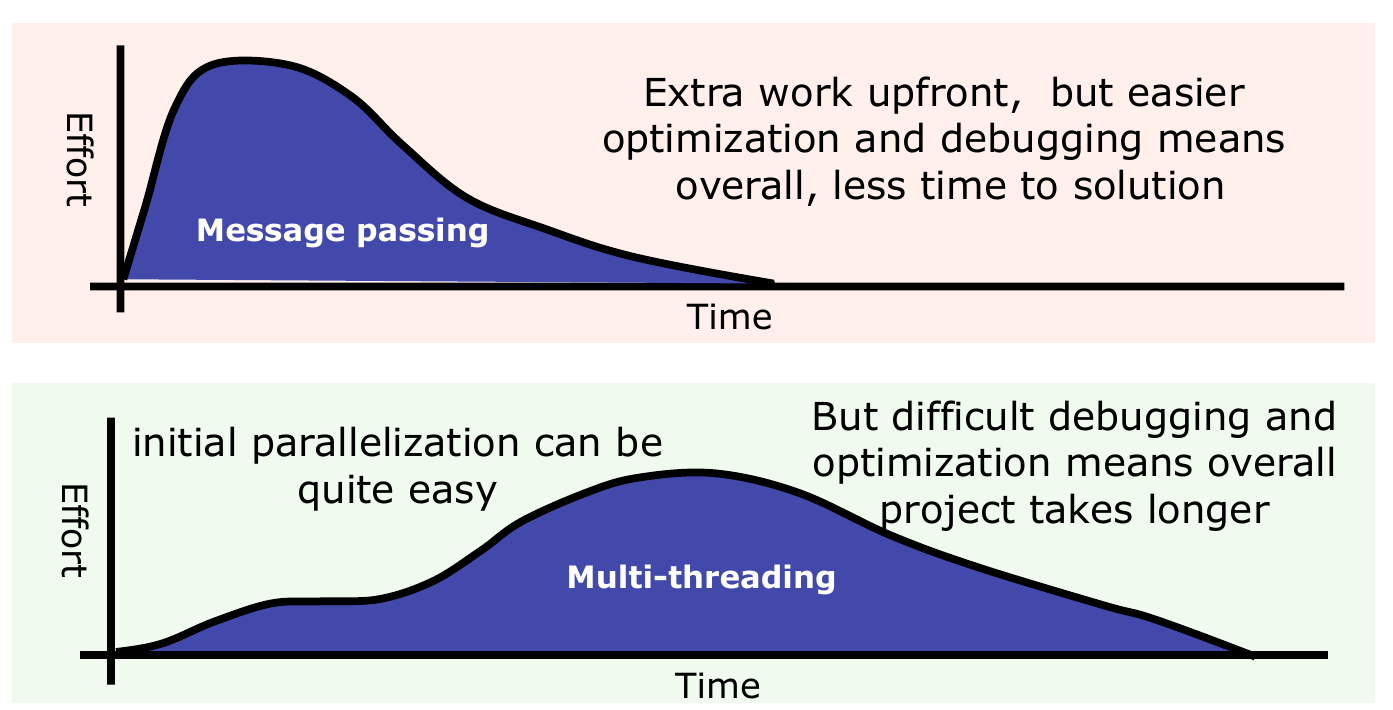

In [70]:
Image("mpi_vs_threads.png")

Things that were not covered:

- Hybrid OpenMP / MPI (try this at home?)
- MPI threads
- Performance and network related issues
- Domain decomposition in more that 1D

### References:

- [This website](#http://mpitutorial.com/tutorials/)
- See above: the [OpenMPI](#https://www.open-mpi.org/) and [MPICH](#https://www.mpich.org/) web pages.  
- [The complete MPI-1.2 and MPI2 specification](#https://www.mcs.anl.gov/research/projects/mpi/mpi-standard/mpi-report-2.0/mpi2-report.htm#Node0).  
- The book by Pacheco: *Parallel Programming with MPI* (978-1558603394)
- [LLNL Tutorial](#https://computing.llnl.gov/tutorials/mpi/)

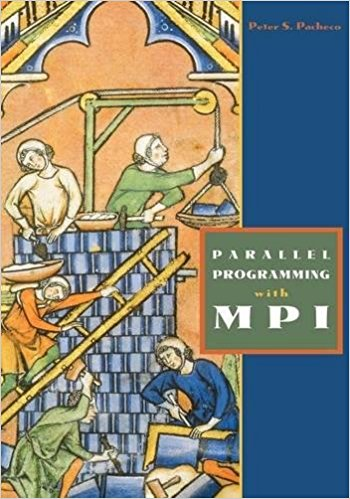

In [71]:
Image("pacheco.jpg")